# Transfer Learning with TensorFlow Part 2: Fine-tuning

# TensorFlow Bölüm 2 ile Öğrenmeyi Aktarın: İnce Ayar

Önceki bölümde, Food Vision projemizde kendi modellerimizi oluşturmaktan (daha az veriyle bile) çok daha iyi sonuçlar elde etmek için özellik çıkarma transferi öğrenmesinden nasıl yararlanabileceğimizi gördük.

Şimdi başka bir transfer öğrenimi türünü ele alacağız: ince ayar.

İnce ayar aktarımı öğrenmede, başka bir modelden önceden eğitilmiş model ağırlıkları, kendi verilerinize daha iyi uyacak şekilde donmamış ve ince ayarlanmıştır.

Özellik çıkarma aktarımı öğrenimi için, önceden eğitilmiş bir modelin en üstteki 1-3 katmanını yalnızca kendi verilerinizle eğitebilirsiniz, ince ayar aktarımı öğreniminde, önceden eğitilmiş bir modelin 1-3+ katmanını eğitebilirsiniz (burada '+', katmanların çoğunun veya tümünün eğitilebileceğini gösterir).

Özellik çıkarma transfer öğrenimi ve ince ayarlı transfer öğrenimi. İkisi arasındaki temel fark, ince ayarda, önceden eğitilmiş modelin daha fazla katmanının dondurulmaması ve özel veriler üzerinde ayarlanmasıdır. Bu ince ayar, etkili olması için genellikle özellik çıkarmadan daha fazla veri alır.

Özellik çıkarımı metoduna göre daha fazla giriş verisi ister. Giriş katman ve çıkış şekli aynıdır, ara katmanlar ile oynanır.

# Çalışma Kitabı İçeriği

* Verilerinize daha uygun olacak şekilde önceden eğitilmiş bir modeli değiştirmek için bir tür aktarım öğrenimi olan fine-tuning'i tanıtın

* Keras İşlevsel API'sini kullanma (Keras'ta modeller oluşturmanın farklı bir yolu)

* Daha hızlı deney yapmak için daha küçük bir veri kümesi kullanmak (örn. 10 sınıf gıdanın eğitim örneklerinin %1-10'u)

* Veri büyütme (daha fazla veri eklemeden eğitim veri kümenizi nasıl daha çeşitli hale getirirsiniz)

* Food Vision verilerimiz üzerinde bir dizi modelleme deneyi yürütmek

  * Model 0: Keras İşlevsel API'sini kullanarak bir aktarma öğrenme modeli

  * Model 1: veri büyütme ile verilerin %1'inde bir özellik çıkarma aktarımı öğrenme modeli

  * Model 2: veri büyütmeli verilerin %10'unda bir özellik çıkarma aktarımı öğrenme modeli

  * Model 3: verilerin %10'unda ince ayarlı bir transfer öğrenme modeli

  * Model 4: verilerin %100'ünde ince ayarlı bir transfer öğrenme modeli

* Ara eğitim sonuçlarını kaydetmek için ModelCheckpoint geri aramasını tanıtın

* TensorBoard kullanarak model deney sonuçlarını karşılaştırın

In [ ]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-04-10 20:29:14.744876


🔑 Not: TensorFlow 2.10+ itibariyle, load_weights() yöntemleri aracılığıyla ağırlıkları yüklerken tf.keras.applications.efficientnet modelleri (daha sonra kullanılan) ile ilgili sorunlar var gibi görünüyor.

Bunu düzeltmek için kodu tf.keras.applications.efficientnet_v2 kullanacak şekilde güncelledim, bu küçük bir değişiklik ama çok daha az hatayla sonuçlanıyor.

GitHub'daki kursta tüm yazıyı görebilirsiniz. https://github.com/mrdbourke/tensorflow-deep-learning/discussions/575

In [ ]:
# Are we using a GPU? (if not & you're using Google Colab, go to Runtime -> Change Runtime Type -> Harware Accelerator: GPU )
!nvidia-smi

Wed Apr 10 20:29:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Yardımcı işlevler oluşturma

Makine öğrenimi deneyleriniz boyunca, muhtemelen tekrar tekrar kullanmak istediğiniz kod parçacıklarıyla karşılaşacaksınız.

Örneğin, bir modelin geçmiş nesnesini çizen bir çizim işlevi (aşağıdaki plot_loss_curves()'e bakın).

Bu işlevleri tekrar tekrar oluşturabilirsiniz.

Ancak tahmin edebileceğiniz gibi, aynı işlevleri yeniden yazmak sıkıcı hale gelir.

Çözümlerden biri, bunları helper_functions.py gibi bir yardımcı komut dosyasında saklamaktır. Ve ardından ihtiyacınız olduğunda gerekli işlevselliği içe aktarın.

Örneğin, şunları yazabilirsiniz:

Helper_functions import plot_loss_curves'tan

...

Plot_loss_curves(tarih)

Python formatında hazırlanan bir fonksiyon github'a yüklenmiş ve o adres üzerinden burada çağrılıyor.

Bu python dosyasının adı helper_function idi. Bu dosyadaki fonksiyon isimleri arasında aşağıda import edilenler vardı.

In [ ]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-04-10 20:29:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-10 20:29:18 (76.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Şimdi her seferinde sıfırdan yeniden yazmak zorunda kalmadan dizüstü bilgisayarda kullanabileceğimiz bir dizi yardımcı işlevimiz var.

🔑 Not: Bu dizüstü bilgisayarı Google Colab'da çalıştırıyorsanız, zaman aşımına girdiğinde Colab helper_functions.py dosyasını silecektir. Bu nedenle, yukarıda içe aktarılan işlevleri kullanmak için hücreyi yeniden çalıştırmanız gerekir.

# 10 Gıda Sınıfı: Daha az veri ile çalışmak

Önceki not defterinde, TensorFlow Hub ile aktarım öğrenimini kullanarak eğitim verilerinin yalnızca %10'u ile harika sonuçlar alabileceğimizi görmüştük.
  * https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb

Bu dizüstü bilgisayarda, verilerin daha küçük alt kümeleriyle çalışmaya devam edeceğiz, ancak bu sefer tf.keras.applications modülündeki yerleşik önceden eğitilmiş modelleri nasıl kullanabileceğimize ve bunları kendi özel veri kümemize nasıl ince ayarlayacağımıza bir göz atacağız.
  * https://www.tensorflow.org/api_docs/python/tf/keras/applications

Ayrıca, tf.keras.utils modülünün bir parçası olan image_dataset_from_directory() ile daha önce kullandığımıza yeni ancak benzer bir veri yükleyici işlevi kullanma alıştırması yapacağız.
  * https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

Son olarak, derin öğrenme modelleri oluşturmak için Keras İşlevsel API'sini kullanarak da pratik yapacağız. İşlevsel API, modeller oluşturmak için tf.keras.Sequential API'den daha esnek bir yoldur.
  * https://keras.io/guides/functional_api/

Gittikçe bunların her birini daha ayrıntılı olarak keşfedeceğiz.

Biraz veri indirerek başlayalım.

İlk kurs materyalinde tüm linkler var.

unzip_data bir helper fonksiyonu.

In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-04-10 20:29:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.207, 74.125.202.207, 74.125.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  92.7MB/s    in 1.7s    

2024-04-10 20:29:28 (92.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



İndirdiğimiz veri kümesi, önceki not defterinde kullandığımız eğitim görüntülerinin %10'unu içeren 10 gıda sınıfı veri kümesidir (Food 101'den).

🔑 Not: Bu veri kümesinin görüntü veri değiştirme not defterinde nasıl oluşturulduğunu görebilirsiniz.
  * https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

Eğitim dizinlerinin her birinin 75 görüntü içerdiğini ve test dizinlerinin her birinin 250 görüntü içerdiğini görebiliriz.

Eğitim ve test dosya yollarımızı tanımlayalım.

In [ ]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Şimdi bazı görüntü verilerimiz var, bunu TensorFlow uyumlu bir formata yüklemenin bir yoluna ihtiyacımız var.

Daha önce ImageDataGenerator sınıfını kullandık.  https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Ancak, Ağustos 2023 itibariyle, bu sınıf kullanımdan kaldırılmıştır ve gelecekteki kullanım için önerilmemektedir (çok yavaştır).

Bu nedenle, tf.keras.utils.image_dataset_from_directory() kullanmaya devam edeceğiz.

Bu yöntem, görüntü verilerini aşağıdaki dosya biçiminde bekler:

ImageDataGenerator yerine tf.keras.prepreprocessing.image_dataset_from_directory() kullanmanın temel faydalarından biri, üretici yerine tf.data.Dataset nesnesi oluşturmasıdır.
  * https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
  * https://www.tensorflow.org/api_docs/python/tf/data/Dataset

Bunun ana avantajı, tf.data.Dataset API'sinin daha büyük veri kümeleri için çok önemli olan ImageDataGenerator API'sinden çok daha verimli (daha hızlı) olmasıdır.

Bunu iş başında görelim.

label_mode;
* int: etiketler sayıya dönüştürüldü, örn sparse_categorical_crossentropy loss
* categorical: etiketler kategorik vektör, örn categorical_crossentropy loss
* binary: etiketler (sadece iki çeşit) float32 tründe 0 ve 1. Örnk binary_crossentropy
* None: etiket yok

çok sınıflı olduğu için vektörel kullandık.

In [ ]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Görünüşe göre veri yükleyicilerimiz her veri kümesi için doğru sayıda görüntü bulmuş.

Şimdilik, image_dataset_from_directory() işlevinde ilgilendiğimiz ana parametreler şunlardır:

* Directory, Dizin - görüntüleri yüklediğimiz hedef dizinin dosya yolu.

* Image_size - yükleyeceğimiz görüntülerin hedef boyutu (yükseklik, genişlik).

* Batch_size - yükleyeceğimiz görüntülerin toplu iş boyutu. Örneğin, batch_size 32 (varsayılan) ise, bir seferde 32 görüntü ve etiketten oluşan gruplar modele geçirilecektir.

[Belgelerde gerekirse oynayabileceğimiz daha çok şey var.
  * https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

Eğitim veri veri türünü kontrol edersek, verilerimizle ilgili şekiller içeren bir BatchDataset olarak görmeliyiz.

In [ ]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

Yukarıdaki çıktıda:

* (None, 224, 224, 3) Hiçbirinin parti boyutu, 224'ün yükseklik (ve genişlik) ve 3'ün renk kanalları (kırmızı, yeşil, mavi) olduğu görüntülerimizin tensör şeklini ifade eder.

* (None, 10), Hiçbirinin parti boyutu ve 10'un olası etiket sayısı (10 farklı gıda sınıfı) olduğu etiketlerin tensör şeklini ifade eder.

* Hem görüntü tensörleri hem de etiketler tf.float32 veri tipindedir.

Batch_size, yalnızca model eğitimi sırasında kullanıldığı için Yok'tur. None'ı image_dataset_from_directory()'den batch_size parametresiyle doldurulmayı bekleyen bir yer tutucu olarak düşünebilirsiniz.

tf.data.Dataset API'sini kullanmanın bir başka yararı da, onunla birlikte gelen ilgili yöntemlerdir.

Örneğin, birlikte çalıştığımız sınıfların adını bulmak istiyorsak, class_names özniteliğini kullanabiliriz.

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Veya örnek bir veri grubu görmek isteseydik, take() yöntemini kullanabiliriz.

In [ ]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 76.07589     39.075893    12.075892  ]
   [ 81.40275     44.402744    17.402742  ]
   [ 82.74107     45.741074    16.741072  ]
   ...
   [ 58.736607    23.736607     4.736607  ]
   [ 58.736607    23.736607     4.736607  ]
   [ 58.736607    23.736607     4.736607  ]]

  [[ 79.86607     42.86607     15.866072  ]
   [ 84.45249     47.452488    20.452488  ]
   [ 85.79465     48.794643    19.794643  ]
   ...
   [ 58.          23.           4.        ]
   [ 58.          23.           4.        ]
   [ 58.          23.           4.        ]]

  [[ 79.91964     41.96875     15.285714  ]
   [ 84.196754    46.245857    19.562819  ]
   [ 85.31696     47.683037    18.683035  ]
   ...
   [ 57.          22.           3.        ]
   [ 57.          22.           3.        ]
   [ 57.          22.           3.        ]]

  ...

  [[  7.           3.           0.        ]
   [  7.           3.           0.        ]
   [  7.           3.           0.        ]
   ...
   [123.384865   106.599

Görüntü dizilerinin, etiketlerin tek sıcak kodlamalar olarak ortaya çıktığı piksel değerlerinin tensörleri olarak nasıl ortaya çıktığına dikkat edin (örn. [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] hamburger için).

Neyin işe yarayıp neyin yaramadığını anlamaya küçük başlayın ve ardından ihtiyacınız olanı ölçeklendirin.
Ve ancak çok sayıda deney yaptıktan sonra bir sezgi geliştirmeye başlayacaksınız.

# Model 0: Keras İşlevsel API'sini kullanarak bir transfer öğrenme modeli oluşturma

Pekala, verilerimiz tensor-ified, hadi bir model oluşturalım.

Bunu yapmak için, modelimizi oluşturmak için bir dizi önceden eğitilmiş (ImageNet'te) bilgisayar görme modelinin yanı sıra Keras Functional API'yi içerdiğinden tf.keras.applications modülünü kullanacağız.  https://www.tensorflow.org/api_docs/python/tf/keras/applications

Aşağıdaki adımlardan geçeceğiz:

1. Tf.keras.applications.efficientnet_v2'den EfficientNetV2B0 gibi bir hedef model seçerek, include_top parametresini False olarak ayarlayarak önceden eğitilmiş bir temel model nesnesini anında oluşturun (bunu yapıyoruz çünkü model için çıktı katmanları olan kendi topumuzu oluşturacağız).
  * https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetV2B0
  * https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2

2. Önceden eğitilmiş modeldeki tüm ağırlıkları dondurmak için temel modelin eğitilebilir özelliğini False olarak ayarlayın.

3. Modelimiz için bir giriş katmanı tanımlayın, örneğin, modelimiz hangi veri şeklini beklemelidir?

4. Gerekiyorsa modelimize girdileri normalleştirin. ResNetV250 gibi bazı bilgisayar görme modelleri, girişlerinin 0 ile 1 arasında olmasını gerektirir.

🤔 Not: Yazma itibariyle, tf.keras.applications modülündeki EfficientNet (ve EfficientNetV2) modelleri, diğer modellerin çoğunda olduğu gibi, girişte görüntülerin normalleştirilmesini (0 ile 1 arasındaki piksel değerleri) gerektirmez. TensorFlow GitHub'a bununla ilgili bir sorun yayınladım ve bunu doğruladılar.  https://github.com/tensorflow/tensorflow/issues/42506

5. Girişleri temel modele iletin.

6. Temel modelin çıktılarını çıktı aktivasyon katmanıyla uyumlu bir şekle dönüştürün (temel model çıktı tensörlerini etiket tensörleriyle aynı şekle dönüştürün). Bu, tf.keras.layers.GlobalAveragePooling2D() veya tf.keras.layers.GlobalMaxPooling2D() kullanılarak yapılabilir, ancak ilki pratikte daha yaygındır.
  * https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D
  * https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en

7. Uygun aktivasyon fonksiyonu ve nöron sayısı ile tf.keras.layers.Dense() kullanarak bir çıkış aktivasyon katmanı oluşturun.

8. tf.keras.Model() kullanarak giriş ve çıkış katmanını bir modelde birleştirin.
  * https://www.tensorflow.org/api_docs/python/tf/keras/Model

9. Uygun kayıp işlevini kullanarak modeli derleyin ve optimize ediciyi seçin.

10. Modeli istenen dönem sayısı ve gerekli geri arama sayısı için sığdırın (bizim durumumuzda, TensorBoard geri arama ile başlayacağız).

Sequential api düz ve sıralıdır, tüm katmanlar sıralı çalışır. Fonksiyonel api daha esnektir.

include_top: Varsayılan olarak ağın en üstüne tam bağlı katmanın dahil edilip edilmeyeceğidir, default hali true. Üst katman hariç mevcut katmanları aynı tutuyoruz. Kendi yoğun katmanımızı kullanmak istediğimiz için false.

EfficientB0'dan B7'ye kadar herhangi birisini seçebilirdin ama karmaşıklık artar.

Üst katman dahil edilmedi, aynı sayıda çıktı katmanı ile üste kendi yoğun katmanımızı eklemek istiyoruz.

Freeze satırı ile base modelin eğitilmediği anlaşılır.

Dördüncü opsiyoneldir.

Altıncı maddede özellik vektörü çıakrtırız.

Eğitim verilerinden daha fazla test verisi aldık. Tüm test verilerinin sadece %25'ini doğrulayacağız böylece modelimiz daha hızlı eğitir.

Callbakc, helper fonksiyon yazılmıştı oradan faydalandık. Dir name, experiment name, current datetime...

Çıktıda GlobalAveragePooling2D() ile yapılan bir özellik vektörüne yoğunlaşmak.

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

24274472/24274472 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240410-203636
Epoch 1/5
24/24 [==============================] - 22s 401ms/step - loss: 1.9344 - accuracy: 0.3760 - val_loss: 1.3992 - val_accuracy: 0.6694
Epoch 2/5
24/24 [==============================] - 3s 126ms/step - loss: 1.1832 - accuracy: 0.7400 - val_loss: 0.9531 - val_accuracy: 0.7681
Epoch 3/5
24/24 [==============================] - 7s 283ms/step - loss: 0.8703 - accuracy: 0.8120 - val_loss: 0.7590 - val_accuracy: 0.8109
Epoch 4/5
24/24 [==============================] - 4s 171ms/step - loss: 0.7159 - accuracy: 0.8373 - val_loss: 0.6658 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 5s 194ms/step - loss: 0.6057 - accuracy: 0.8667 - val_loss: 0.6097 - val_accuracy: 0.8487


Bir dakika kadar eğitimden sonra modelimiz hem eğitimde hem de test setlerinde inanılmaz derecede iyi performans gösterir.

TensorFlow Hub modelleriyle yaptığımıza benzer şekilde, burada kullandığımız transfer öğreniminin özellik çıkarma transfer öğrenmesi olarak adlandırıldığını not etmek önemlidir.

Başka bir deyişle, özel verilerimizi önceden eğitilmiş bir modele (EfficientNetV2B0) aktardık, "hangi kalıpları görüyorsunuz?" diye sorduk. Ve daha sonra çıktıların istenen sınıf sayısına göre uyarlandığından emin olmak için kendi çıktı katmanımızı üstüne koyun.

Ayrıca Modelimizi oluşturmak için Sıralı API yerine Keras İşlevsel API'sini kullandık. Şimdilik, bu ana şebekenin faydaları net görünmüyor, ancak daha karmaşık modeller oluşturmaya başladığınızda, muhtemelen İşlevsel API'yi kullanmak isteyeceksiniz. Bu nedenle, bu şekilde model oluşturmaya maruz kalmak önemlidir.

📖 Kaynak: Sıralı API'ye karşı İşlevsel API'nin faydalarını ve kullanım durumlarını görmek için TensorFlow Functional API belgelerine göz atın. https://www.tensorflow.org/guide/keras/functional_api

Modelimizdeki katmanları inceleyelim, tabandan başlayacağız.

model_0.evaluate(test_data) kodunu da çalıştır. accuracy:%83.



In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

Bu çok fazla katman... tüm bunları elle kodlamak oldukça uzun zaman alırdı, ancak transfer öğrenmenin gücü sayesinde yine de onlardan avantaj alabiliriz.

Temel modelin bir özetine ne dersiniz?

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

Farklı katmanların her birinin nasıl belirli sayıda parametreye sahip olduğunu görebilirsiniz. Önceden eğitilmiş bir model kullandığımız için, tüm bu parametrelerin temel modelin başka bir veri kümesinde öğrendiği kalıplar olduğunu düşünebilirsiniz. Ve base_model.trainable = False ayarladığımız için, bu kalıplar eğitim sırasında olduğu gibi kalır (donmuşlardır ve güncellenmezler).

Pekala, temel model buydu, genel modelimizin özetini görelim.

Tek eğitilebilir parametreler çıktı katmanındakilerdir.

In [ ]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

Genel modelimiz beş katmana sahiptir, ancak gerçekten, bu katmanlardan biri (efficientnetv2-b0) 269 katmana sahiptir.

Çıkış şeklinin giriş katmanı (görüntülerimizin şekli) için (Yok, 224, 224, 3) olarak nasıl başladığını, ancak çıktı katmanı (etiketlerimizin şekli) tarafından (Yok, 10) dönüştürüldüğünü görebilirsiniz, burada Yok, parti boyutu için yer tutucudur.

Dikkat edin, modeldeki tek eğitilebilir parametreler çıktı katmanındaki parametrelerdir.

Modelimizin eğitim eğrileri nasıl görünüyor?

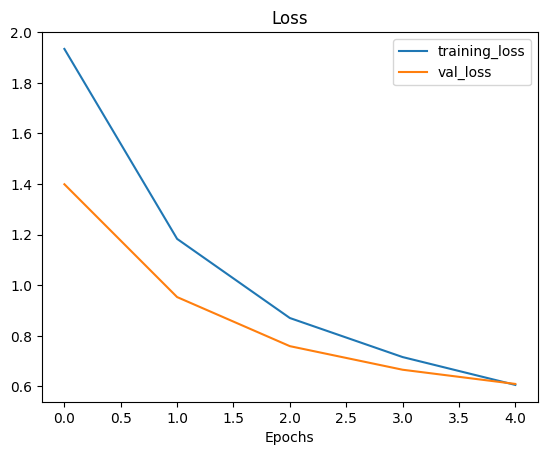

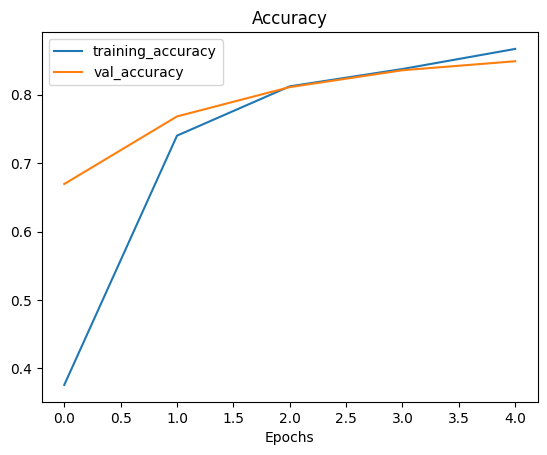

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

Global..girmeden önce şekil 4 parça iken çıkarken iki parçaya döndü.

Globalpool fonksiyonlarından bir kaç çeşit var.

# Eğitimli bir modelden bir özellik vektörü almak

🤔 Soru: tf.keras.layers.GlobalAveragePooling2D() katmanına ne oluyor? Daha önce görmedim.

tf.keras.layers.GlobalAveragePooling2D() katmanı, iç eksenler arasındaki değerlerin ortalamasını alarak bir 4D tensörü 2D tensörüne dönüştürür. https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D

Bir önceki cümle biraz ağız dolusu, o yüzden bir örnek görelim.

In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


Tf.keras.layers.GlobalAveragePooling2D() katmanının giriş tensörünü şekilden (1, 4, 4, 3) şeklinden (1, 3) daha küçük bir vektöre yoğunlaştırdığını görebilirsiniz. Bunu, orta iki eksen boyunca input_tensor'un ortalamasını alarak yaptı.

Bu işlemi tf.reduce_mean() işlemini kullanarak ve uygun eksenleri belirterek çoğaltabiliriz.

In [ ]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Bunu yapmak, temel modelin çıktısını sadece çıktı katmanımızın (tf.keras.layers.Dense()) giriş şekli gereksinimi ile uyumlu hale getirmekle kalmaz, aynı zamanda temel model tarafından bulunan bilgileri daha düşük bir boyut özellik vektörüne yoğunlaştırır.

🔑 Not: Ekstraksiyon aktarımı öğrenmesinin nedenlerinden biri, nasıl olduğu olarak adlandırılır, çünkü sık sık olan şey, önceden eğitilmiş bir modelin bir özellik vektörü (uzun bir sayı tensörü, bizim durumumuzda, bu, daha sonra kalıpları çıkarmak için kullanılabilen tf.keras.layers.GlobalAveragePooling2D() katmanının çıktısıdır) çıktısıdır. https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D

🛠Alıştırma: Yukarıdaki hücreyle aynı şeyi yapın, ancak tf.keras.layers.GlobalMaxPool2D() için. https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D

Temel modelimizin bir görüntüde ne olduğu hakkında öğrendiği özellikleri çıkarmak istiyoruz. Bu, modelimizin belirli bir görüntü veya veri örneğinden geçtiğini öğrendiği temsildir. Ve sonra çıktı katmanını bu konuda eğitiyoruz.

Özellik vektörü: Giriş verilerinin öğrenilmiş gösterimidir (giriş verilerinin sıkıştırılmış ve modeli nasıl gördüğü ile ilgili)

Input data -- models layers (learns feature representation of input data) -- output data (feature vectors)

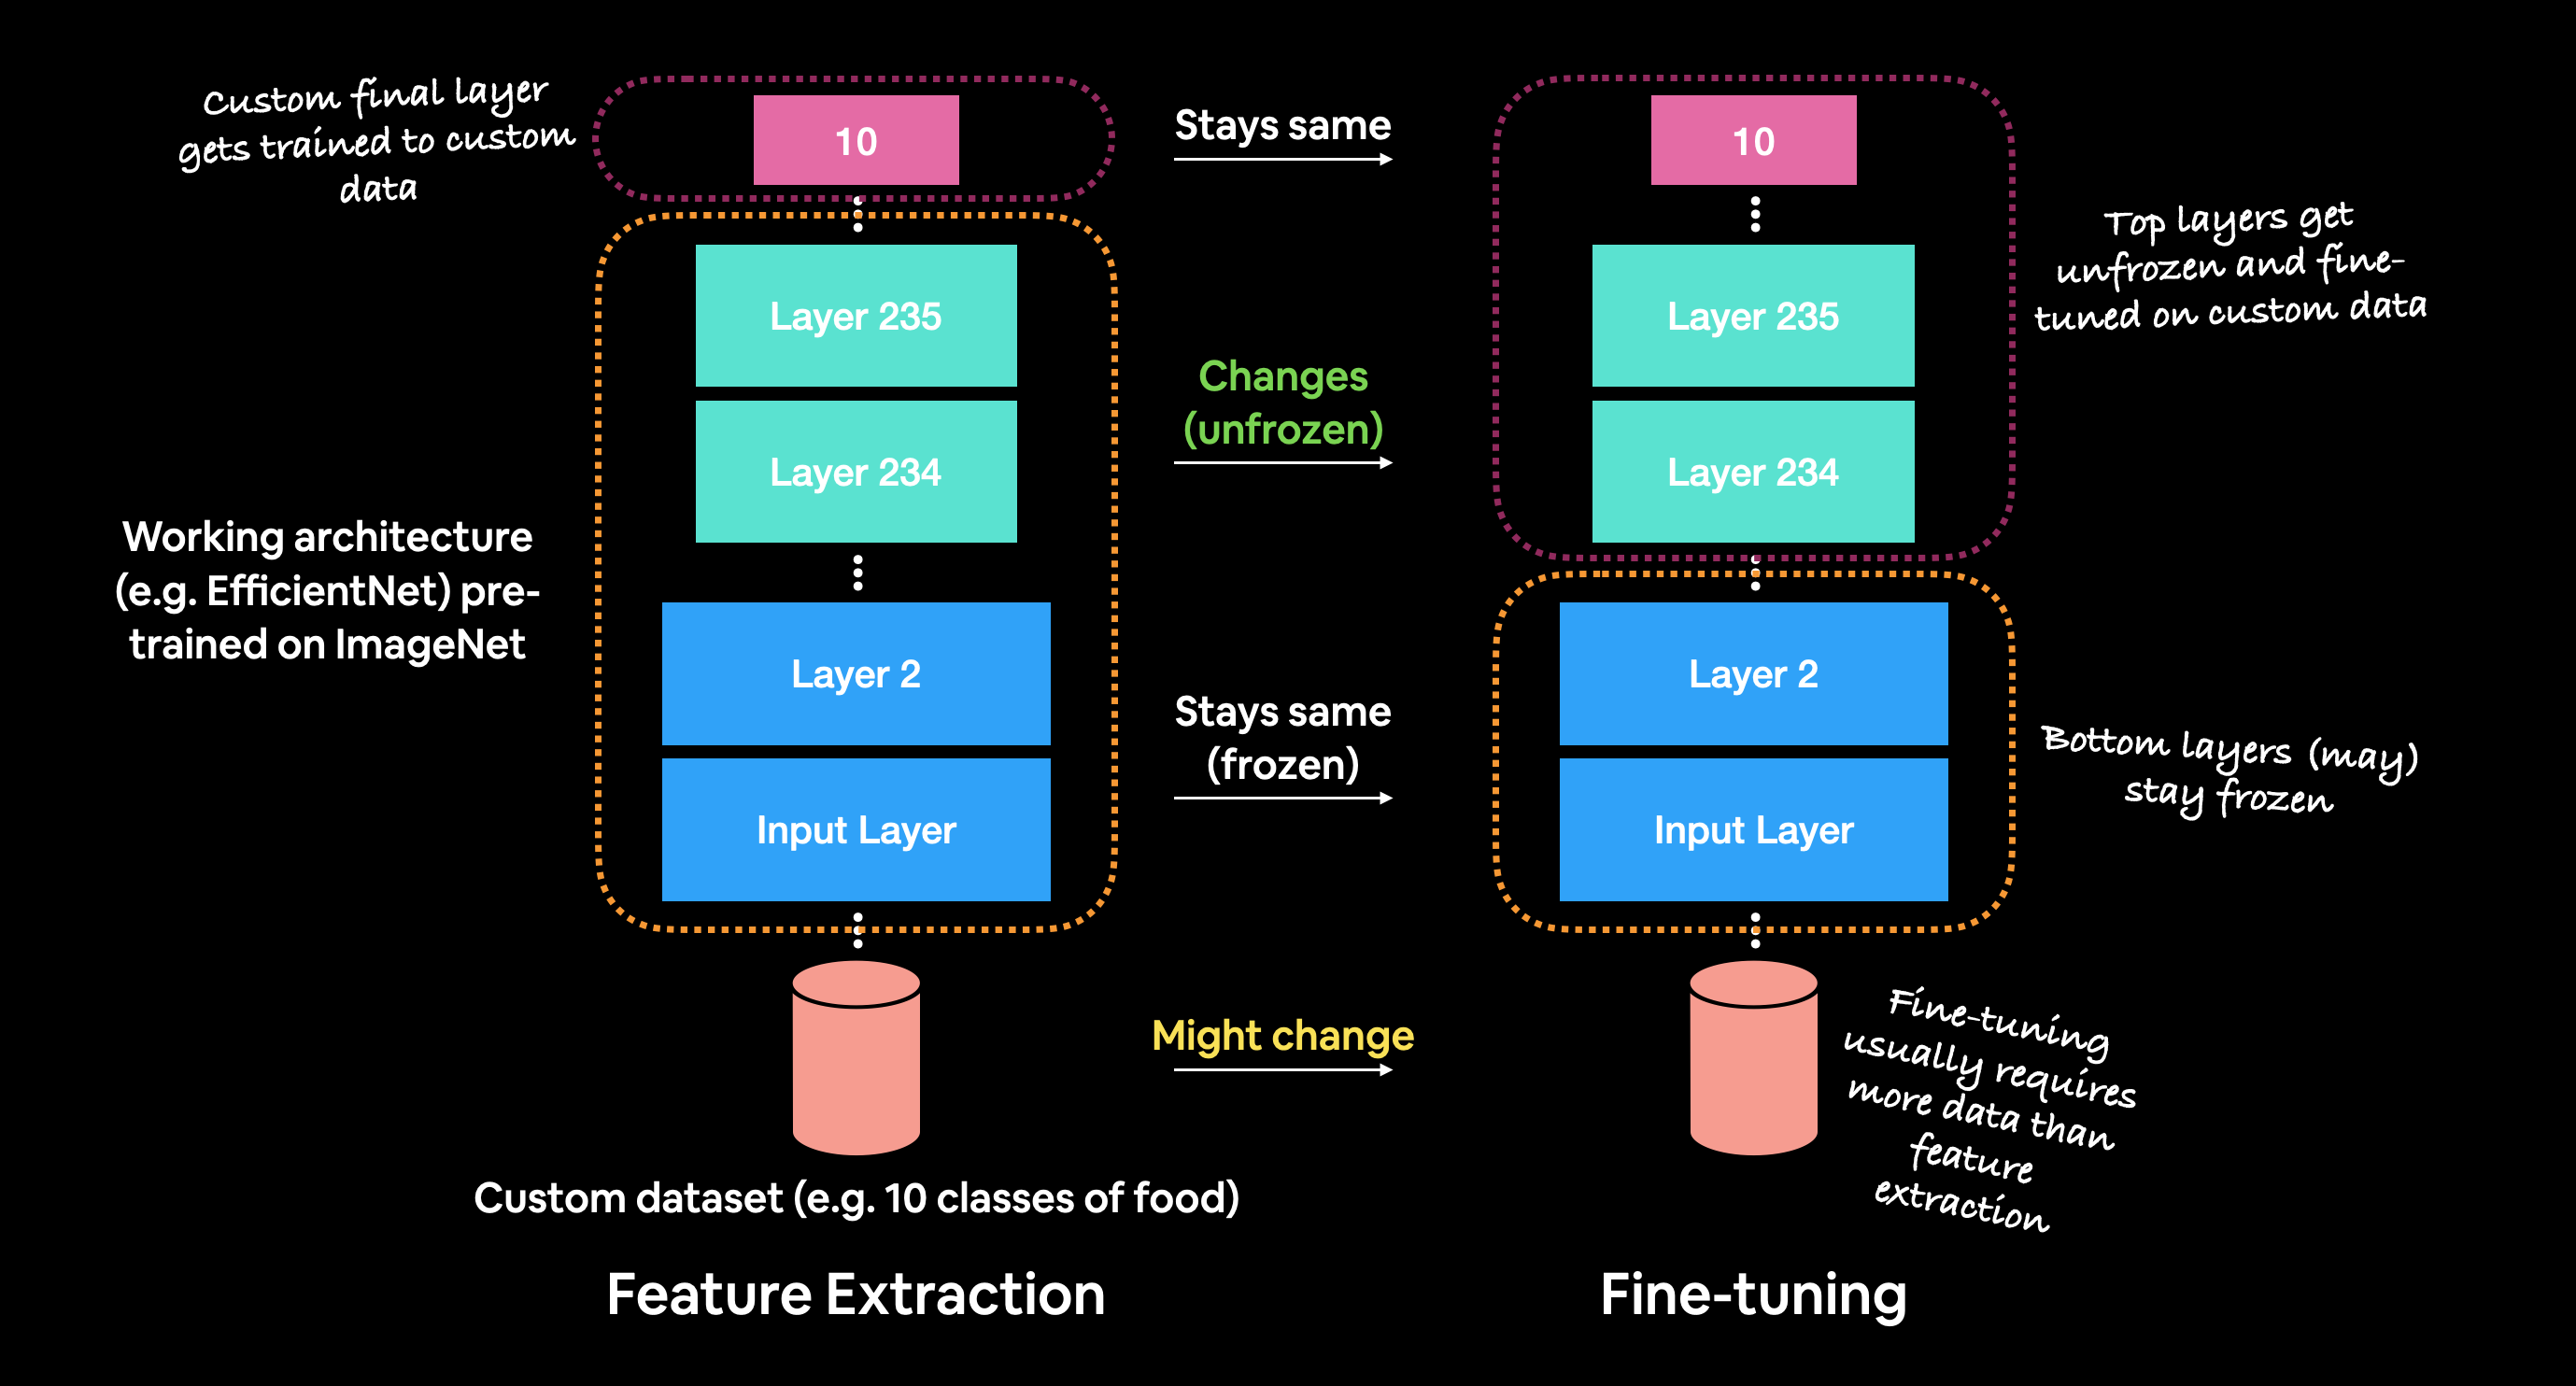

In [ ]:
from IPython.display import display, Image

# Resmin URL'si
image_url = "https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png"

# Resmi göster
display(Image(image_url))


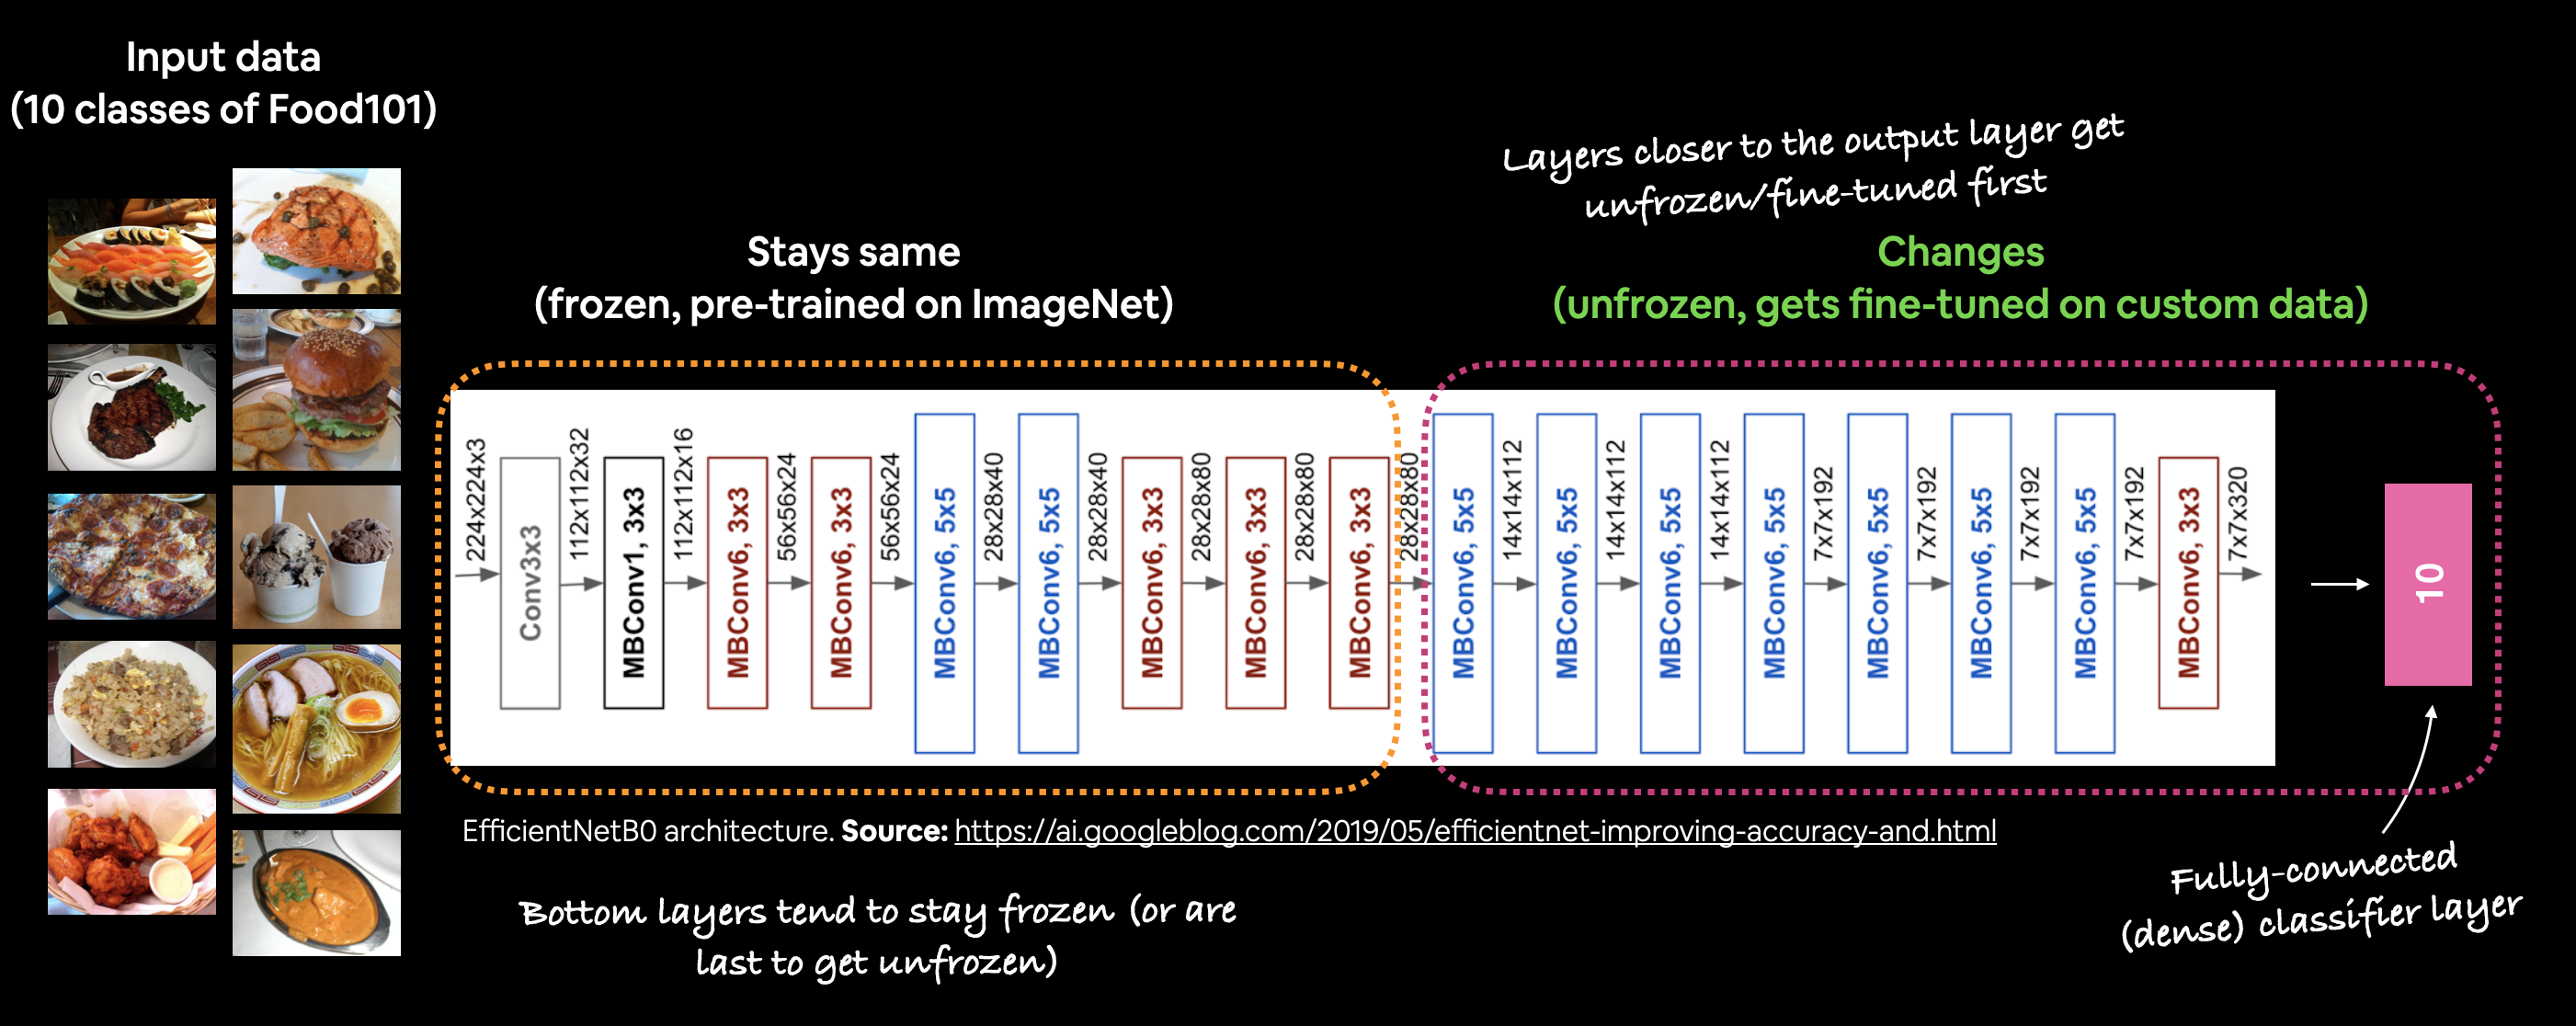

In [ ]:
from IPython.display import display, Image

# Resmin URL'si
image_url = "https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/05-fine-tuning-an-efficientnet-model.png"

# Resmi göster
display(Image(image_url))


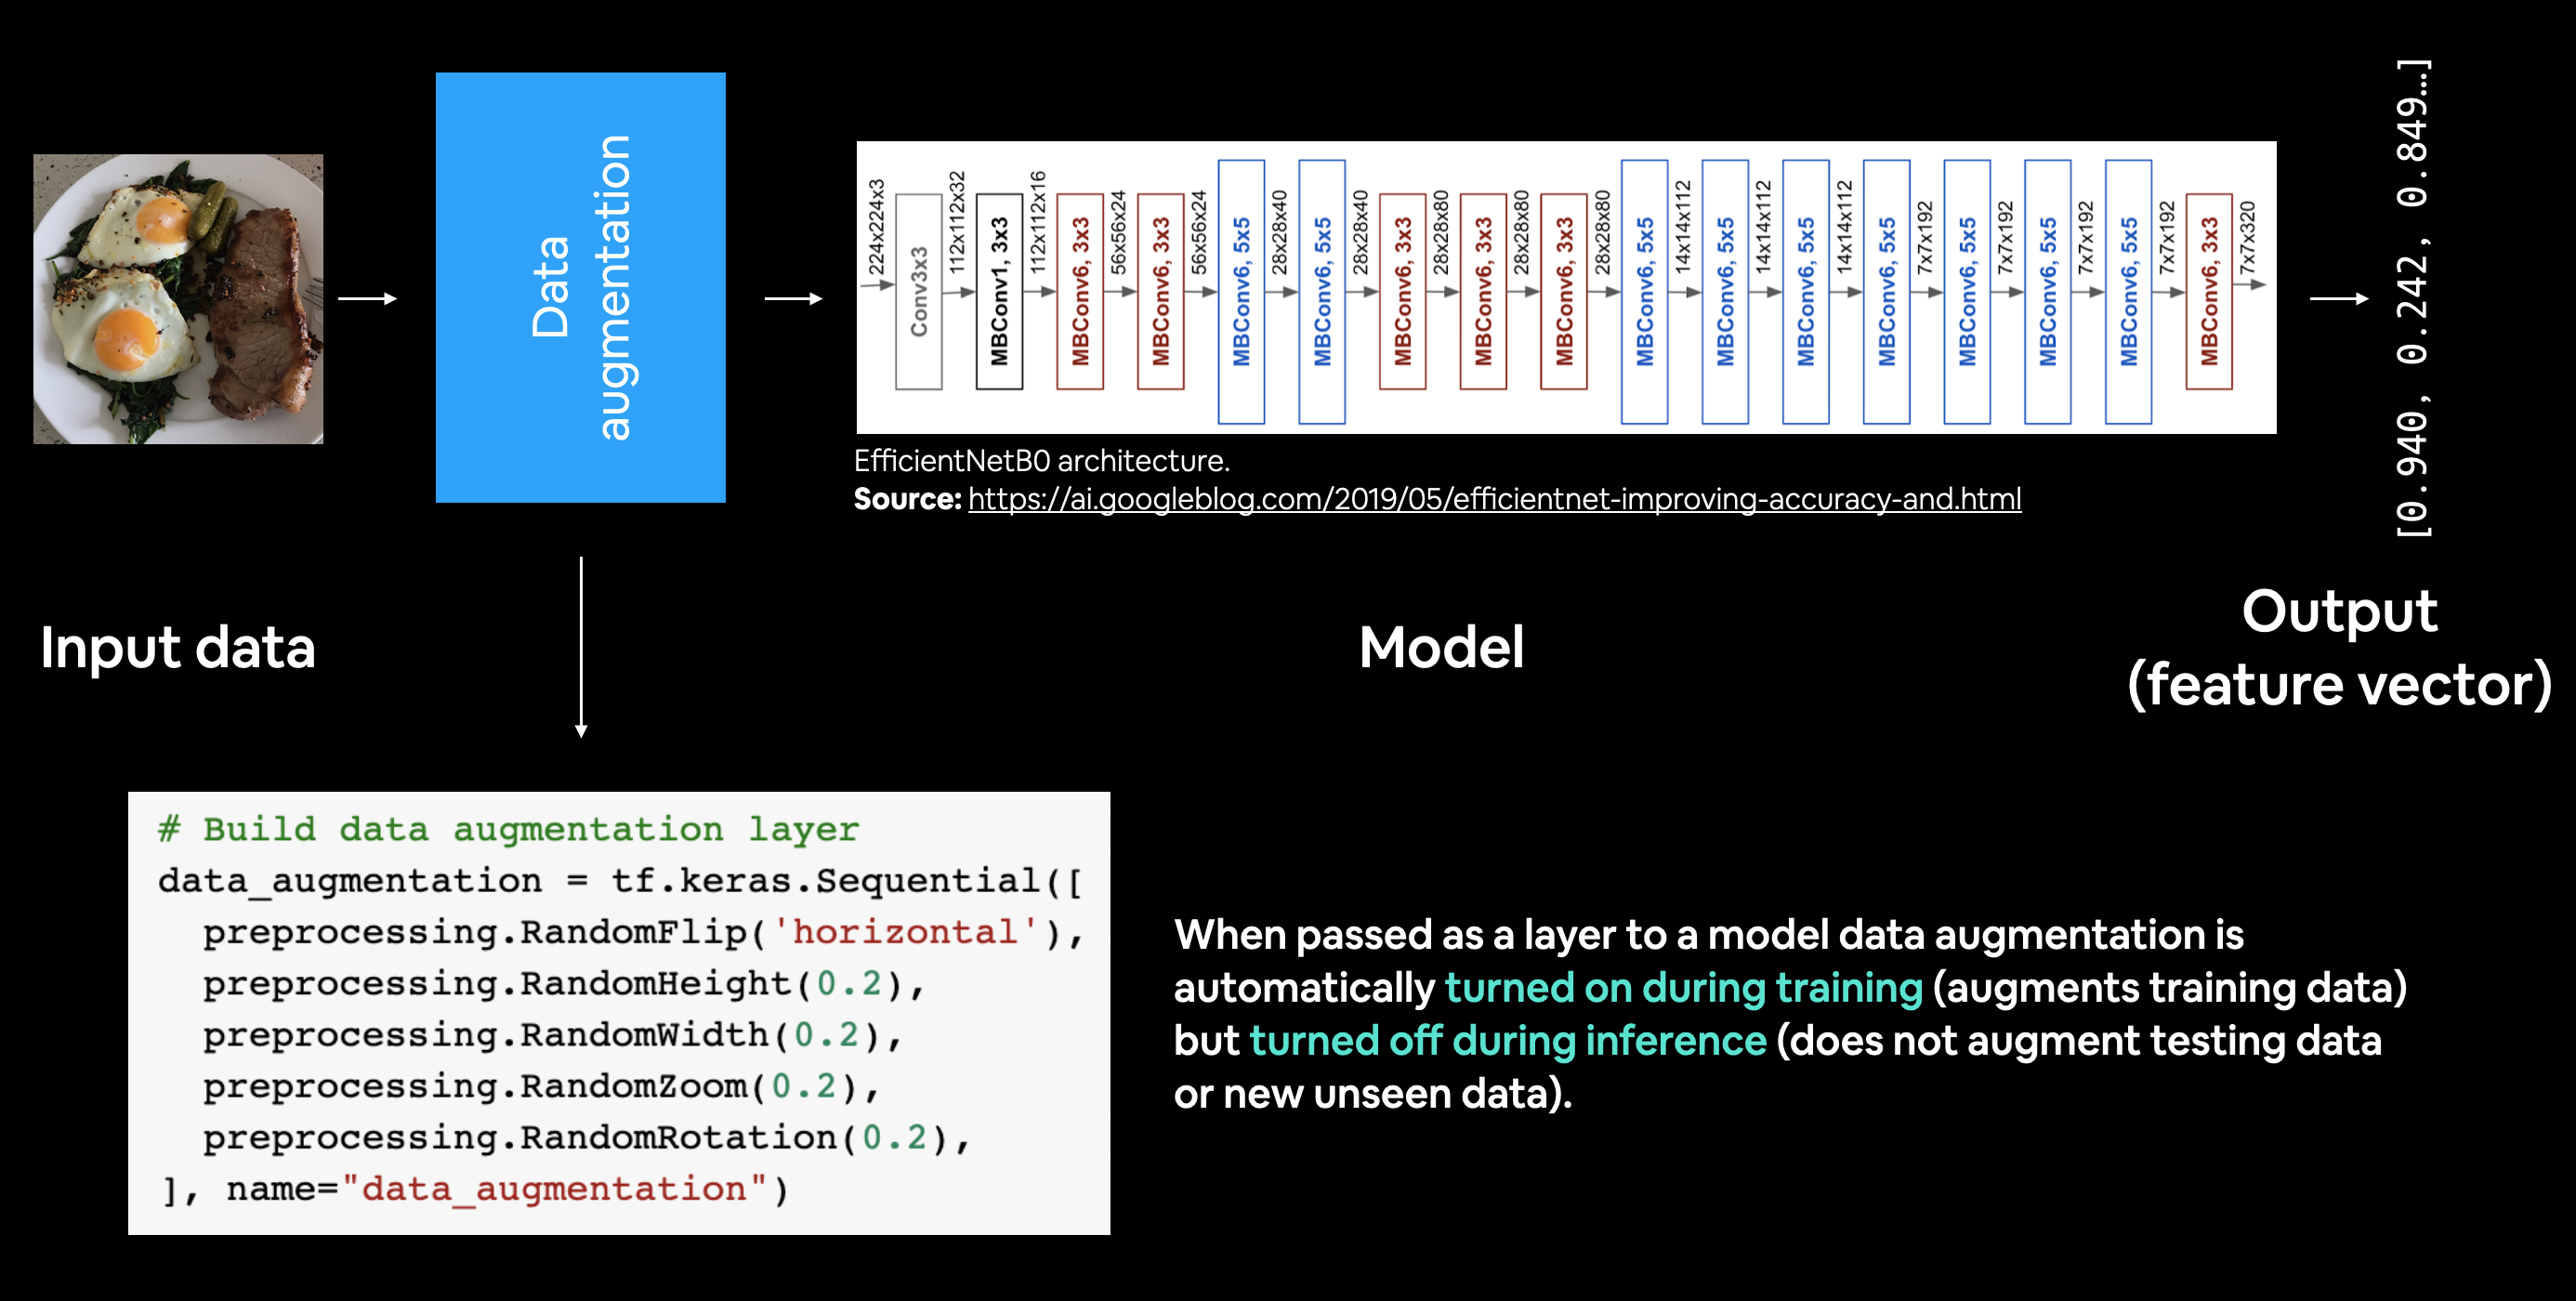

In [ ]:
from IPython.display import display, Image

# Resmin URL'si
image_url = "https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/05-data-augmentation-inside-a-model.png"

# Resmi göster
display(Image(image_url))


# Bir dizi transfer öğrenme deneyi yürütmek

Eğitim verilerinin %10'unda aktarım öğreniminin inanılmaz sonuçlarını gördük, eğitim verilerinin %1'i ne olur?

Kendi oluşturduğumuz orijinal CNN modellerinden 100 kat daha az veri kullanarak ne tür sonuçlar elde edebileceğimizi düşünüyorsunuz?

Aşağıdaki modelleme deneylerini çalıştırırken neden bu soruyu cevaplamıyoruz:

1. Model 1: Veri büyütme ile eğitim verilerinin %1'inde özellik çıkarma aktarımı öğrenmesini kullanın.

2. Model 2: Veri büyütme ile eğitim verilerinin %10'unda özellik çıkarma aktarımı öğrenimini kullanın ve sonuçları bir kontrol noktasına kaydedin.

3. Model 3: Model 2 kontrol noktasında, veri büyütme ile eğitim verilerinin %10'u üzerinde ince ayar yapın.

4. Model 4: Veri büyütme ile eğitim verilerinin %100'ünde Model 2 kontrol noktasında ince ayar yapın.

Tüm deneyler eğitim verilerinin farklı versiyonlarında çalıştırılacak olsa da, hepsi aynı test veri seti üzerinde değerlendirilecektir, bu da her deneyin sonuçlarının mümkün olduğunca karşılaştırılabilir olmasını sağlar.

Tüm deneyler, tf.keras.applications.efficientnet_v2 modülü içindeki EfficientNetV2B0 modeli kullanılarak yapılacaktır.

Deneylerimizi takip ettiğimizden emin olmak için, tüm model eğitim günlüklerini günlüğe kaydetmek için create_tensorboard_callback() işlevimizi kullanacağız.

Her modeli Keras İşlevsel API'sini kullanarak oluşturacağız ve daha önce olduğu gibi ImageDataGenerator sınıfında veri büyütme uygulamak yerine, tf.keras.layers modülünü kullanarak doğrudan modele inşa edeceğiz. https://www.tensorflow.org/api_docs/python/tf/keras/layers/

Veri büyütme ile eğitim verilerinin %1'inde özellik çıkarma aktarım öğrenimini kullanarak deney 1 için verileri indirerek başlayalım.

Hangi deneyleri yapıp yapmayacağını bilmek için deneyler yaparak sonuca ulaşırsın.

Helper fonksiyonu ile sürekli uzun uzun unzip fonk. yazmaktan kurtuldun. Normalde o fonksiyondaki her şeyi buraya yazmalısın.

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2024-04-10 20:44:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.207, 142.250.159.207, 142.251.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   155MB/s    in 0.8s    

2024-04-10 20:44:20 (155 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

Pekala, görünüşe göre her sınıftan sadece yedi görüntümüz var, bu modelimiz için biraz zor olmalı.

🔑 Not: Veri alt kümesinin %10'unda olduğu gibi, görüntülerin %1'i orijinal tam eğitim veri kümesinden rastgele seçilmiştir. Test görüntüleri daha önce kullanılanlarla aynıdır. Bu verilerin nasıl önceden işlendiğini görmek istiyorsanız, Food Vision Image Preprocessing not defterine bakın. https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

Görüntülerimizi tf.data.Dataset nesneleri olarak yükleme zamanı, bunu yapmak için image_dataset_from_directory() yöntemini kullanacağız. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Doğrudan modele veri büyütme ekleme

Daha önce eğitim görüntülerimizi büyütmek için ImageDataGenerator sınıfının farklı parametrelerini kullandık, bu sefer doğrudan modele veri büyütme oluşturacağız.

Nasıl?

Tf.keras.layers modülünü kullanma ve özel bir veri büyütme katmanı oluşturma. https://www.tensorflow.org/api_docs/python/tf/keras/layers

Bu, TensorFlow 2.10+'a eklenen nispeten yeni bir özellik ama çok güçlü. Modele bir veri büyütme katmanı eklemek aşağıdaki faydalara sahiptir:

* Görüntülerin ön işlenmesi (onları büyütme) CPU'da (çok daha hızlı) yerine GPU'da gerçekleşir.

  * Görüntüler, metin ve yapılandırılmış verilerin CPU'da önceden işlenmeye daha uygun olduğu GPU'da en iyi şekilde önceden işlenir.

* Görüntü verisi büyütme yalnızca eğitim sırasında gerçekleşir, böylece tüm modelimizi dışa aktarabilir ve başka bir yerde kullanabiliriz. Ve bir başkası, aynı tür veri büyütme de dahil olmak üzere bizimle aynı modeli eğitmek isterse, yapabilirdi.

📚 Kaynak: Farklı veri büyütme yöntemleri hakkında daha fazla bilgi için TensorFlow veri büyütme kılavuzuna göz atın. https://www.tensorflow.org/tutorials/images/data_augmentation?hl=tr

Veri büyütmeyi doğrudan modelimizde kullanmak için, yalnızca veri ön işleme katmanlarından oluşan bir Keras Sequential modeli oluşturacağız, daha sonra bu Sıralı modeli başka bir İşlevsel modelde kullanabiliriz.

Bu kafa karıştırıcı geliyorsa, kodda oluşturduğumuzda mantıklı olacaktır.

Kullanacağımız veri büyütme dönüşümleri şunlardır:

* tf.keras.layers.RandomFlip - görüntüyü yatay veya dikey eksende çevirir. https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip

* tf.keras.layersRandomRotation - görüntüyü rastgele belirli bir miktarda döndürür. https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation

* tf.keras.layers.RandomZoom - bir görüntüyü belirtilen miktarda rastgele yakınlaştırır. https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom

* tf.keras.layers.RandomHeight - görüntü yüksekliğini rastgele belirli bir miktarda kaydırır. https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomHeight

* tf.keras.layers.RandomWidth - görüntü genişliğini rastgele belirli bir miktarda kaydırır. https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomWidth

* tf.keras.layers.Rescaling - görüntü piksel değerlerini 0 ile 1 arasında olacak şekilde normalleştirir, bu bahsetmeye değer çünkü bazı görüntü modelleri için gereklidir, ancak tf.keras.applications.efficientnet_v2 kullanıyoruz. EfficientNetV2B0, gerekli değildir (önceden eğitilmiş model modeli kendini yeniden ölçeklendirmeyi uygular). https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling

Daha fazla seçenek var ama bunlar şimdilik yapacak.

rescaling --> Resimlerinizi tutarlı bir şekle yeniden boyutlandırmak için ön işleme çizgilerini kullanabilirsiniz, böylece hepsini yeniden boyutlandırabiliriz.


aumentation layer --> bir modelde bir katmandan geçildiiğinde eğitim sırasında otomatik olarak açılır (eğitim verileri) ama etki sırasında ise kapatılır (görülmemiş verilerde veya test verilerinde veri büyütme olmaz).

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

# # UPDATE: Previous versions of TensorFlow (e.g. 2.4 and below used the tensorflow.keras.layers.experimental.processing API)
# # Create a data augmentation stage with horizontal flipping, rotations, zooms
# data_augmentation = keras.Sequential([
#   preprocessing.RandomFlip("horizontal"),
#   preprocessing.RandomRotation(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
# ], name ="data_augmentation")

Veri büyütme Sıralı modelimiz kullanıma hazır. Kısa süre sonra göreceğiniz gibi, bu "modeli" daha sonra transfer öğrenme modelimize bir katman olarak yerleştirebileceğiz.

Ama bunu yapmadan önce, içinden rastgele görüntüler geçirerek test edelim.

augmented_img = data_augmentation(img, training=True)

Rastgele seçim. Rastgele seçimin yolu yazdırılıp o görüntü yüklenir. Her kodu çalıştırdığında yeni resim gelir.

plt.axis(False) --> görselde 100-200 gibi ölçekler vardı onlar gider.

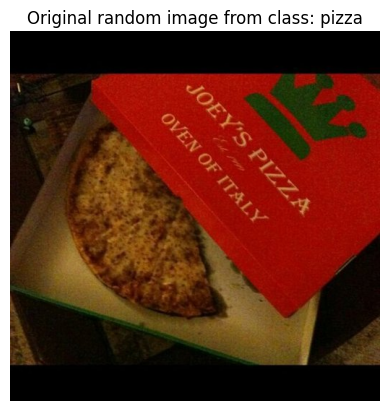

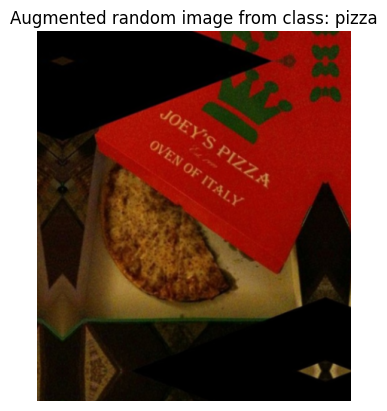

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

Hücreyi birkaç kez yukarıda çalıştırın ve farklı görüntü sınıflarında farklı rastgele büyütmeleri görebilirsiniz. Yaklaşan aktarım öğrenme modelimize veri büyütme modelini bir katman olarak ekleyeceğimiz için, bu tür rastgele büyütmeleri, içinden geçen eğitim görüntülerinin her birine uygulayacaktır.

Bunu yapmak, eğitim veri setimizi biraz daha çeşitli hale getirecektir. Bunu gerçek hayatta bir yemek fotoğrafı çekiyormuşsunuz gibi düşünebilirsiniz, tüm görüntüler mükemmel olmayacak, bazıları garip şekillerde yönlendirilecek. Bunlar, modelimizin işleyebilmesini istediğimiz türden görüntüler.

Modelden bahsetmişken, İşlevsel API ile bir tane oluşturalım. Bir fark dışında daha önce olduğu gibi tüm adımları gözden geçireceğiz, veri büyütme Sıralı modelimizi giriş katmanından hemen sonra bir katman olarak ekleyeceğiz.

# Model 1: Veri büyütme ile verilerin %1'inde özellik çıkarma aktarımı öğrenimi

IMG_SIZE = (224, 224)

IMG_SIZE + (3, ) = (224, 224, 3)

Çok sınıflı olduğu için softmax.

keras.Model(inputs, outputs) --> girdiler birleşir ve çıktıya ulaşır.

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240410-205603
Epoch 1/5
3/3 [==============================] - 17s 4s/step - loss: 2.2745 - accuracy: 0.1000 - val_loss: 2.1375 - val_accuracy: 0.2105
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 2.0558 - accuracy: 0.2429 - val_loss: 2.0421 - val_accuracy: 0.2845
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 1.9130 - accuracy: 0.4286 - val_loss: 1.9544 - val_accuracy: 0.3569
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7541 - accuracy: 0.5571 - val_loss: 1.8502 - val_accuracy: 0.4671
Epoch 5/5
3/3 [==============================] - 6s 2s/step - loss: 1.6867 - accuracy: 0.6714 - val_loss: 1.7559 - val_accuracy: 0.5345


Bu ne kadar havalı? Sınıf başına sadece 7 eğitim görüntüsü kullanarak, transfer öğrenimini kullanarak modelimiz doğrulama setinde ~%45+ doğruluk elde edebildi.

Orijinal Food-101 makalesi tüm verilerle %50.67 doğruluk elde ettiğinden, yani sınıf başına 750 eğitim görüntüsü (not: bu metrik 10 değil 101 sınıftaydı, yakında 101 sınıfa ulaşacağız). https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Modelimizin bir özetine bakarsak, giriş katmanından hemen sonra veri büyütme katmanını görmeliyiz.

In [ ]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

İşte orada. Artık modelimizde yerleşik olarak veri büyütmemiz var. Bu, onu kaydedip başka bir yere yeniden yüklersek, veri büyütme katmanlarının onunla birlikte geleceği anlamına gelir.

Hatırlanması gereken önemli şey, veri büyütmenin yalnızca eğitim sırasında çalışmasıdır. Bu nedenle, modelimizi çıkarım için değerlendirecek veya kullanacak olsaydık (bir görüntünün sınıfını tahmin ederek) veri büyütme katmanları otomatik olarak kapatılacaktır.

Bunu çalışırken görmek için modelimizi test verileri üzerinde değerlendirelim.

In [ ]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 86ms/step - loss: 1.7685 - accuracy: 0.5272


[1.768502950668335, 0.5271999835968018]

Buradaki sonuçlar, eğitim sırasında modelimizin günlük çıktılarından biraz daha iyi/daha kötü olabilir, çünkü eğitim sırasında modelimizi yalnızca validation_steps=int(0.25 * len(test_data)) satırını kullanarak test verilerinin %25'inde değerlendiriyoruz. Bunu yapmak çağlarımızı hızlandırır, ancak yine de bize modelimizin nasıl gittiğine dair yeterince fikir verir.

Tutarlı kalalım ve modelimizin kayıp eğrilerini kontrol edelim.

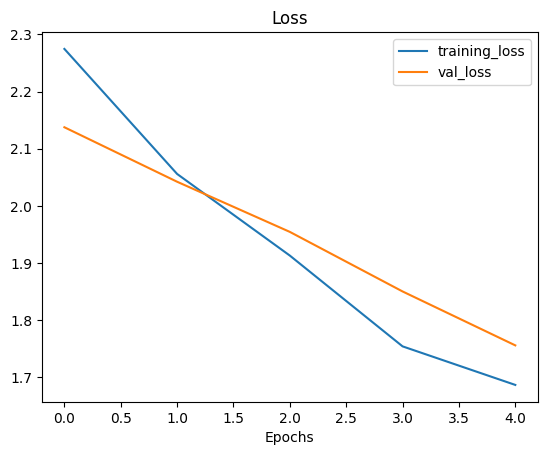

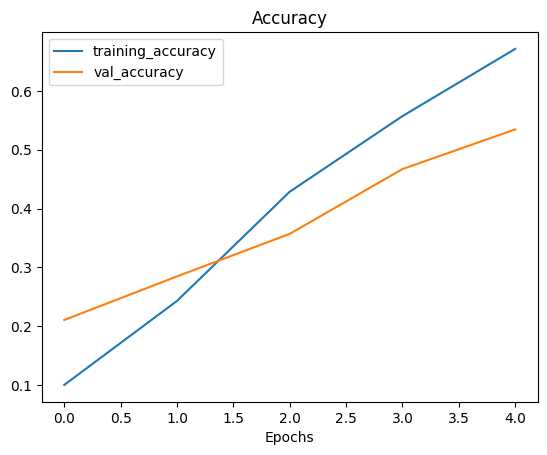

In [ ]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

Daha fazla dönem için eğitime devam edersek, her iki veri kümesindeki metrikler iyileşecek gibi görünüyor. Ama bunu şimdilik bırakacağız, yapacak daha çok deneyimiz var!

# Model 2: Verilerin %10'u ve veri büyütme ile özellik çıkarma aktarımı öğrenimi

Pekala, eğitim verilerinin %1'ini veri büyütme ile test ettik, verilerin %10'unu veri büyütme ile denemeye ne dersiniz?

Ama bekle...

🤔 Soru: Hangi deneylerin çalıştırılacağını nereden biliyorsunuz?

Harika soru.

Buradaki gerçek şu ki, çoğu zaman yapmayacaksın. Makine öğrenimi hala çok deneysel bir uygulamadır. Sadece birkaç şeyi denedikten sonra ne deneyeceğinize dair bir sezgi geliştirmeye başlayacaksınız.

Benim tavsiyem, merakınızı olabildiğince azimle takip etmenizdir. Bir şey denemek istediğinizi düşünüyorsanız, bunun kodunu yazın ve çalıştırın. Nasıl gittiğini görün. Olacak en kötü şey, neyin işe yaramadığını, en değerli bilgi türünü anlayacaksınız.

Pratik bir bakış açısından, daha önce konuştuğumuz gibi, ilk deneyleriniz arasındaki süreyi mümkün olduğunca azaltmak isteyeceksiniz. Başka bir deyişle, umut verici bir şey bulmadan önce daha az veri ve daha az eğitim yinelemesi kullanarak çok sayıda küçük deney çalıştırın ve ardından ölçeklendirin.

Ölçek temasında, %1 eğitim veri büyütme deneyimizi %10'a kadar ölçeklendirelim eğitim verisi büyütme. Bu cümle gerçekten mantıklı değil ama ne demek istediğimi anlıyorsun.

Önceki modelle tamamen aynı adımlardan geçeceğiz, tek fark %1 yerine eğitim verilerinin %10'unu kullanmak.

In [ ]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Veriler indirildi. Veri yükleyicileri oluşturalım.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Test datalarında 250'şer fotoğraf, train datalarında 75'er fotoğraf.

Çalışmak için 10 kat daha fazla resmimiz var, sınıf başına 7 yerine sınıf başına 75.

Yerleşik veri büyütme ile bir model oluşturalım. Daha önce oluşturduğumuz veri büyütme Sıralı modelini yeniden kullanabiliriz, ancak uygulama için yeniden oluşturacağız.

preprocessing --> Efficient modeli zaten bunu yapmıştı ama Resetnet modeli kullanıyorsan bunu yapmalısın.

In [ ]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

## OLD
# # Build data augmentation layer
# data_augmentation = Sequential([
#   preprocessing.RandomFlip('horizontal'),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomRotation(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

x = base_model(x, training=False) :

Özel bir katman türü var ve karşılaştığınız birçok önceden eğitilmiş model bu katmanı kullanacak.
Buna parti normalleştirme denir,

Temel modeli çağırırken training = False yaptık, böylece bir çıkarım yürütülür. Böylece toplu norm istatistikleri, ince ayar için temel modeli çözdükten sonra bile güncellenmez.

Ancak bu, daha sonra modellerimizi, Bache Norm Katmanları olan katmanları ince ayarladığımızda önemlidir. İnce ayar sırasında dondurulmamalıdır çünkü bu istatistikler, kalıpları aynı kalmalıdır. Muhtemelen ince ayar sırasında değiştirilmemesi gereken tek istisna katmanıdır.

En son,
Veriler burada sığmıyor. Model kontrol noktası geri arama oluştururuz. Callback model eğitimini kurtarır, her epoch'da modelin kontrol noktaları olarak öğrendiği kalıpları kaydeder

Daha sonrası için zaman kazanmak için (model_2 ile birden fazla deney yapmak istediğimizde), yukarıdaki kodu yeniden kullanabileceğimiz bir işleve koyalım.

In [ ]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

# ModelCheckpoint geri arama oluşturma

Modelimiz derlenmiş ve formda olmaya hazır, öyleyse neden henüz uymadık?

Bu deney için yeni bir geri arama, ModelCheckpoint geri aramasını tanıtacağız.

ModelCheckpoint geri araması, modelinizi bir bütün olarak SavedModel biçiminde veya ağırlıkları (desenler) yalnızca eğitilirken belirli bir dizine kaydetme olanağı sağlar.
  * https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
  * https://www.tensorflow.org/tutorials/keras/save_and_load?hl=tr#save_the_entire_model
  * https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights

Bu, modelinizin uzun süre eğitim alacağını düşünüyorsanız ve eğitirken yedeklerini almak istiyorsanız yararlıdır. Ayrıca, modelinizin daha uzun süre eğitim almaktan fayda sağlayabileceğini düşünüyorsanız, belirli bir kontrol noktasından yeniden yükleyebileceğiniz ve oradan eğitime devam edebileceğiniz anlamına gelir.

Örneğin, 5 dönem için bir özellik çıkarma aktarımı öğrenme modeline uyduğunuzu ve eğitim eğrilerini kontrol ettiğinizi ve hala geliştiğini gördüğünüzü ve başka bir 5 dönem için ince ayarın yardımcı olup olmadığını görmek istediğinizi varsayalım, kontrol noktasını yükleyebilir, temel model katmanlarının bir kısmını (veya tümünü) çözebilir ve ardından eğitime devam edebilirsiniz.

Aslında, tam olarak yapacağımız şey bu.

Ama önce bir ModelCheckpoint geri araması oluşturalım. Bunu yapmak için, kaydetmek istediğimiz bir dizini belirtmemiz gerekir.

Callback faydalı araçlardır, eğitim, değerlendirme veya çıkarımda (kanıtlanmış ve sonuca ulaşmış durum) faydalı fonksiyonellik ekler, bazı önemli geri aramalar;

* Tensorboard

* Early Stopping

* Model Kontrol Noktası: Model eğitilirken onu kaydedebiliriz böylece ihtiyaç anında eğitimi durdurabiliriz ve bıraktığın yere devam etmek için geri gelebilirsin. Eğitim uzun süreceği ve tek oturuşta yapılamayacağı durumlarda faydalıdır.


In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

🤔 Soru: Tüm modeli (SavedModel formatı) kaydetmek ile sadece ağırlıkları kaydetmek arasındaki fark nedir?

SavedModel formatı, bir modelin mimarisini, ağırlıklarını ve eğitim yapılandırmasını tek bir klasöre kaydeder. Modelinizi tam olarak başka bir yerde olduğu gibi yeniden yüklemeyi çok kolaylaştırır. Bununla birlikte, tüm bu ayrıntıları başkalarıyla paylaşmak istemiyorsanız, yalnızca ağırlıkları kaydetmek ve paylaşmak isteyebilirsiniz (bunlar sadece insan olmayan yorumlanabilir sayıların büyük tensörleri olacaktır). Disk alanı bir sorunsa, yalnızca ağırlıkları kaydetmek daha hızlıdır ve tüm modeli kaydetmekten daha az yer kaplar. https://www.tensorflow.org/tutorials/keras/save_and_load?hl=tr#save_the_entire_model

Modele uyma zamanı.

Daha sonra ince ayar yapacağımız için, bir initial_epochs değişkeni oluşturacağız ve daha sonra kullanmak üzere 5'e ayarlayacağız.

Geri arama listemize checkpoint_callback'imizi de ekleyeceğiz.

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240410-210929
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0138 - accuracy: 0.3520
Epoch 1: val_loss improved from inf to 1.50858, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 38s 1s/step - loss: 2.0138 - accuracy: 0.3520 - val_loss: 1.5086 - val_accuracy: 0.6201
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4236 - accuracy: 0.6387
Epoch 2: val_loss improved from 1.50858 to 1.09430, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 26s 1s/step - loss: 1.4236 - accuracy: 0.6387 - val_loss: 1.0943 - val_accuracy: 0.7681
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1200 - accuracy: 0.7187
Epoch 3: val_loss improved from 1.09430 to 0.87695, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=======

ModelCheckpoint geri aramamız işe yaradı ve modelimiz her dönem ağırlıklarını çok fazla ek yük olmadan kurtardı (tüm modeli kurtarmak sadece ağırlıklardan daha uzun sürer).

Modelimizi değerlendirelim ve kayıp eğrilerini kontrol edelim.

In [ ]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 79ms/step - loss: 0.6717 - accuracy: 0.8256


[0.6717445254325867, 0.8256000280380249]

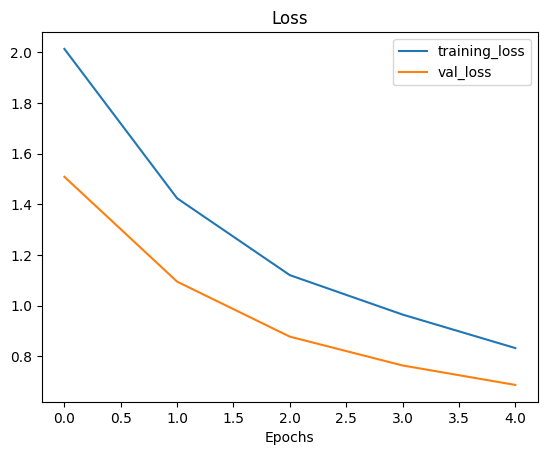

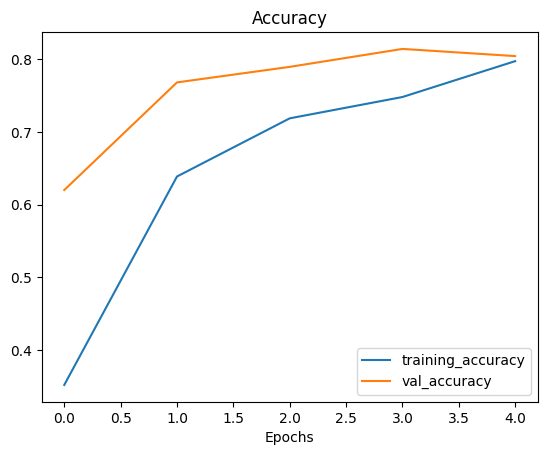

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

Bunlara baktığımızda, modelimizin verilerin %10'u ve veri büyütme ile performansı, veri büyütme olmadan verilerin %10'una sahip model kadar iyi değil (yukarıdaki model_0 sonuçlarına bakın), ancak eğriler doğru yönde ilerliyor, yani daha uzun süre eğitmeye karar verirsek, metrikleri muhtemelen iyileşecektir.

Kontrol noktası yaptığımızdan beri (bu bir kelime mi?) Modelimizin ağırlıkları, onu tekrar yüklemenin nasıl bir şey olduğunu da görebiliriz. Test verileri üzerinde değerlendirerek doğru şekilde kaydedilip kaydedilmediğini test edebileceğiz.

Kaydedilen model ağırlıklarını yüklemek için load_weights() yöntemini kullanabilir ve kaydedilen ağırlıklarınızın depolandığı yolu geçirebilirsiniz. https://www.tensorflow.org/tutorials/keras/save_and_load?hl=tr#checkpoint_callback_options

ikinci model bu kontrol noktası dosyasında depolanan aynı ağırlıklara sahip. Çalışıp çalışmadığını görmek için test etmemizin yolu, ağırlıkları dosyadan yeniden yüklememizdir.
Bu nedenle, zaten ikinci modelde olan ağırlıkları geçersiz kılın ve ardından modelimizi değerlendirin ve sonuçların olup olmadığına bakın. Yüklenen beyazların mevcut ağırlıklarla aynı sonuçları alır.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.6717 - accuracy: 0.8256


Şimdi daha önce eğitilmiş modelimizin ve yüklü modelin sonuçlarını karşılaştıralım. Bu sonuçlar tam olarak aynı değilse de çok yakın olmalıdır. Küçük farklılıkların nedeni, hesaplanan sayıların hassasiyet seviyesine iner.

In [ ]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

Yukarıdaki hücre True çıktısı vermiyorsa, bunun nedeni sayıların yakın olması ancak tam olarak aynı olmamasıdır (bilgisayarların sayıları hassasiyet dereceleriyle nasıl sakladığı nedeniyle).

Ancak, çok yakın olmalılar...

isclose --> iki farklı sayı kümesini karşılaştırmak için.

In [ ]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results (small values)
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


# Model 3: Verilerin %10'u üzerinde mevcut bir modeli ince ayarlama

EfficientNet modelinin ince ayarını yapmak için üst düzey örnek. Eğitim sırasında üst katmanlar (çıkış verilerine daha yakın katmanlar) güncellendiğinde alt katmanlar (giriş verilerine daha yakın katmanlar) donmuş kalır.

Şimdiye kadar kaydedilen modelimiz, eğitim verilerinin %10'unda ve veri büyütmede 5 dönem için özellik çıkarma aktarımı öğrenimi kullanılarak eğitildi.

Bu, temel modeldeki (EfficientNetV2B0) tüm katmanların eğitim sırasında dondurulduğu anlamına gelir.

Bir sonraki deneyimiz için ince ayarlı transfer öğrenimine geçeceğiz. Bu, bazı katmanlarını (üste en yakın olanları) dondurmamız ve modeli birkaç dönem daha çalıştırmamız dışında aynı temel modeli kullanacağımız anlamına gelir.

İnce ayar ile ilgili fikir, önceden eğitilmiş modeli kendi verilerimize göre daha fazla özelleştirmeye başlamaktır.

🔑 Not: İnce ayar genellikle birkaç dönem için ve büyük miktarda veriyle bir özellik çıkarma modelini eğittikten sonra en iyi şekilde çalışır. Bununla ilgili daha fazla bilgi için, Keras'ın Transfer öğrenimi ve ince ayar kılavuzuna göz atın.

Yüklü modelimizin performansını doğruladık, katmanlarını kontrol edelim.

https://keras.io/guides/transfer_learning/

Modeli beş dönem beklemek için kaydediyoruz.
Şimdi modele ince ayar yapacağız, gerçekten bir model üç, Modelin sadece ince ayarlanmış bir versiyonu.

In [ ]:
# Layers in loaded model
model_2.layers

İsimlerini, numaralarını ve eğitilebilir olup olmadıklarını kontrol etmeye ne dersiniz?

In [ ]:
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x7bdbd6c80dc0> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.src.engine.sequential.Sequential object at 0x7bdbd9615660> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.src.engine.functional.Functional object at 0x7bdbd6aa99f0> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7bdbd6bea020> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.src.layers.core.dense.Dense object at 0x7bdbd6c52050> | Trainable? True


False olanlar eğitilebilir değiller.

Bir giriş katmanımız, bir Sıralı katmanımız (veri büyütme modeli), bir İşlevsel katmanımız (EfficientNetV2B0), bir havuzlama katmanımız ve bir Yoğun katmanımız (çıkış katmanı) var.

Bir özete ne dersin?

In [ ]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

Pekala, efficientnetv2-b0 katmanındaki tüm katmanlar donmuş gibi görünüyor. Bunu trainable_variables özniteliğini kullanarak onaylayabiliriz.

Not: model_2'nin base_model katmanlarına (efficientnetv2-b0 özellik çıkarıcımız) model_2.layers[2] referansıyla erişilebilir.

In [ ]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

Eğitilebilir bir değişken, güncellenebilen bir ağırlık veya modeldir.

In [ ]:
# How many layers are trainable in our model_2_base_model?
print(len(model_2_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)

0


Eğitilebilir olup olmadıklarını görmek için katman katman bile kontrol edebiliriz.

Model_2_base_model'deki katmanlara erişmek için layers özniteliğini kullanabiliriz.

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

Güzel. Tam olarak peşinde olduğumuz şey bu.

Şimdi temel modeli kendi verilerimize göre ince ayar yapmak için, en iyi 10 katmanı çözeceğiz ve modelimizi 5 dönem daha eğitmeye devam edeceğiz.

Bu, son 10 hariç tüm temel modelin katmanlarının donmuş ve eğitilemez kalacağı anlamına gelir. Ve kalan donmamış katmanlardaki ağırlıklar antrenman sırasında güncellenecektir.

İdeal olarak, modelin performansının iyileştiğini görmeliyiz.

🤔 Soru: Antrenman yaparken kaç katmanı çözmelisiniz?

Bunun için belirlenmiş bir kural yok. Önceden eğitilmiş modeldeki her katmanı çözebilir veya her seferinde bir katmanı çözmeyi deneyebilirsiniz. Ne olduğunu görmek için farklı miktarlarda dondurma ve ince ayar yapmayı denemek en iyisidir. Genel olarak, ne kadar az veriye sahipseniz, o kadar az katmanı çözmek ve yavaş yavaş ince ayar yapmak istersiniz.

📖 Kaynak: ULMFiT (Metin Sınıflandırması için Evrensel Dil Modeli İnce Ayar) makalesi, ince ayar modelleri üzerinde harika bir dizi deneye sahiptir. https://arxiv.org/abs/1801.06146

İnce ayar yapmaya başlamak için, eğitilebilir özelliğini True olarak ayarlayarak tüm model_2_base_model'i çözeceğiz.

Ardından, son 10 hariç model_2_base_model'deki her katmanı döngüleyerek ve eğitilebilir niteliklerini False olarak ayarlayarak yeniden donduracağız.

Son olarak, tüm modeli yeniden derleyeceğiz.

print(layer.name) --> python giriş konusu :)

In [ ]:
# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])


Önceden eğitilmiş modelin hangi katmanlarının eğitilebilir olduğunu kontrol edelim.

Ve mevcut bir model, bu ağırlıkların çok fazla güncellenmesini ve hangi güncellemeleri hatırlamasını istemiyoruz.

Öğrenme oranı, bir modelin iç kalıplarını veya iç ağırlıklarını ne kadar güncellemesi gerektiğini belirler. Optimize edicinin yanı sıra kayıp işleve dayalı olarak epoch'tan epoch'a veya sample'dan sample'a.
Bu nedenle, ince ayar ile, bu katmanlar mevcut bir veri kümesinde bazı kalıpları zaten öğrendiğinden,
bu kalıpları büyük ölçüde değiştirmesini istemiyoruz çünkü bu aşırı uyumla sonuçlanacak.

İnce ayar, öğrenme oranını değiştirmektir, bu nedenle Adam'ın varsayılan öğrenme oranını kullanıyoruz. 0.001 bir öğrenme oranını düşürmektir.
10x'e kadar, bu bir temel kural.  Genellikle öğrenme oranınızı düşürmek istersiniz.

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

Güzel! Son 10 hariç tüm katmanlar donmuş ve eğitilemez gibi görünüyor. Bu, çıkış katmanıyla birlikte temel modelin yalnızca son 10 katmanının antrenman sırasında ağırlıklarının güncelleneceği anlamına gelir.

🤔 Soru: Modeli neden yeniden derledik?

Modellerinizde her değişiklik yaptığınızda, onları yeniden derlemeniz gerekir.

Bizim durumumuzda, daha önce olduğu gibi aynı kaybı, optimize ediciyi ve metrikleri kullanıyoruz, ancak bu sefer optimize edicimizin öğrenme oranı öncekinden 10 kat daha küçük olacak (Adam'ın varsayılanı olan 0.001 yerine 0.0001).

Bunu, modelin önceden eğitilmiş modeldeki mevcut ağırlıkların üzerine çok hızlı yazmaya çalışmaması için yapıyoruz. Başka bir deyişle, öğrenmenin daha kademeli olmasını istiyoruz.

🔑 Not: İnce ayar sırasında öğrenme oranını ayarlamak için belirlenmiş bir standart yoktur, ancak 2.6x-10x+'lık indirimler pratikte iyi çalışıyor gibi görünmektedir. https://arxiv.org/abs/1801.06146

Şu anda kaç tane eğitilebilir değişkenimiz var?

In [ ]:
print(len(model_2.trainable_variables))

12


Harika, modelimizde toplam 12 eğitilebilir değişken, temel modelin son 10 katmanı ve Yoğun çıktı katmanının ağırlık ve önyargı parametreleri var gibi görünüyor.

İnce ayar zamanı!

Önceki modelimizin bittiği yerden eğitime devam edeceğiz. 5 çağ için eğitildiği için ince ayarımız 5. çağda başlayacak ve 5 dönem daha devam edecek.

Bunu yapmak için fit() yönteminin initial_epoch parametresini kullanabiliriz. Önceki modelin eğitim geçmişinin son dönemini geçeceğiz (history_10_percent_data_aug.epoch[-1]). https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240410-212033
Epoch 5/10
24/24 [==============================] - 34s 927ms/step - loss: 0.7004 - accuracy: 0.8120 - val_loss: 0.5005 - val_accuracy: 0.8322
Epoch 6/10
24/24 [==============================] - 21s 883ms/step - loss: 0.6314 - accuracy: 0.8080 - val_loss: 0.5044 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - 21s 870ms/step - loss: 0.5708 - accuracy: 0.8133 - val_loss: 0.4618 - val_accuracy: 0.8520
Epoch 8/10
24/24 [==============================] - 20s 806ms/step - loss: 0.5012 - accuracy: 0.8413 - val_loss: 0.4673 - val_accuracy: 0.8503
Epoch 9/10
24/24 [==============================] - 15s 611ms/step - loss: 0.4674 - accuracy: 0.8507 - val_loss: 0.4359 - val_accuracy: 0.8553
Epoch 10/10
24/24 [==============================] - 15s 589ms/step - loss: 0.4338 - accuracy: 0.8787 - val_loss: 0.4643 - val_accuracy: 0.8569


🔑 Not: İnce ayar genellikle dönem başına özellik çıkarmadan çok daha uzun sürer (bir ağ genelinde daha fazla ağırlığın güncellenmesi nedeniyle).

Modelimiz birkaç yüzde doğruluk puanı kazandı! Bunu değerlendirelim.

In [ ]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 68ms/step - loss: 0.4466 - accuracy: 0.8520


Unutmayın, eğitim sırasında test verilerinin yalnızca %25'ini değerlendirdiğimiz için modeli değerlendirmenin sonuçları eğitimden elde edilen çıktılardan biraz farklı olabilir.

Pekala, ince ayardan önce ve sonra modelimizin performansını değerlendirmenin bir yoluna ihtiyacımız var. Öncesini ve sonrasını karşılaştırmak için bir işlev yazmaya ne dersiniz?

plot_loss_curves(history_fine_10_percent_data_aug)...

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

Model eğitimimizin geçmiş değişkenlerini kaydetmenin kullanışlı olduğu yer burasıdır. Modelimizin son 10 katmanını ince ayar yaptıktan sonra ne olduğunu görelim.

5
11
[0.35199999809265137, 0.6386666893959045, 0.718666672706604, 0.7480000257492065, 0.7973333597183228, 0.8119999766349792, 0.8080000281333923, 0.8133333325386047, 0.8413333296775818, 0.8506666421890259, 0.8786666393280029]


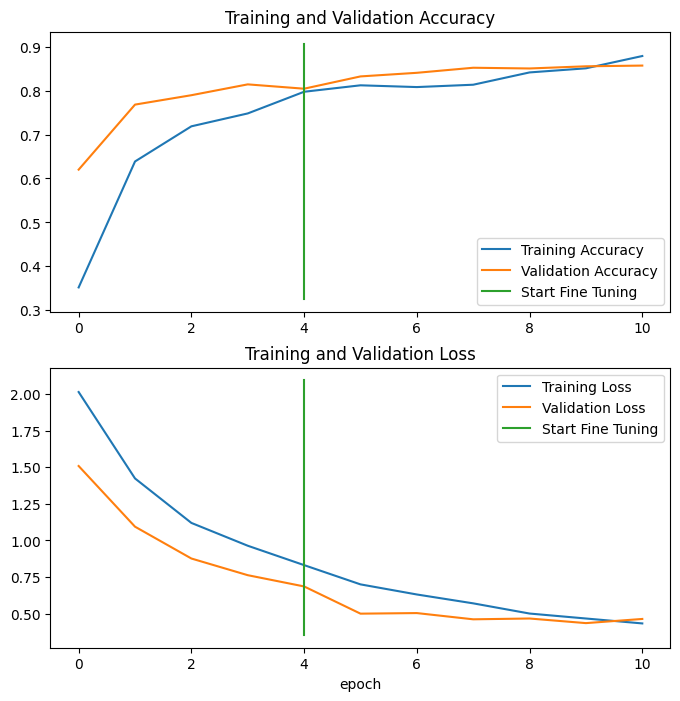

In [ ]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

Aşağıdaki grafikte epoch 10'dan sonra model aşırı uymaya başlıyor.

Pekala, tamam, fine-tuning'den sonra eğriler doğru yönde ilerliyor gibi görünüyor. Ancak unutmayın, ince ayarın genellikle daha büyük miktarda veriyle en iyi şekilde çalıştığına dikkat edilmelidir.

# Model 4: Mevcut bir modelin tüm verilerini ince ayarlama

İnce ayar fazla veriyle daha iyi çalışır. Bir modelin genellikle daha fazla veriyle nasıl çalıştığı hakkında yeterince konuşma, hadi deneyelim.

10 gıda sınıfı veri setimizin tam sürümünü indirerek başlayacağız.

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2024-04-10 21:23:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.207, 64.233.183.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  51.9MB/s    in 12s     

2024-04-10 21:23:25 (39.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Ah bu iyi görünüyor. Birlikte çalışmak için eğitim sınıflarında 10 kat daha fazla görüntümüz var.

Test veri kümesi, önceki deneylerimiz için kullandığımızla aynıdır.

Şimdi olduğu gibi, model_2'miz verilerin yüzde 10'unda ince ayarlı, bu nedenle tüm verilerde ince ayar yapmaya başlamak ve deneylerimizi tutarlı tutmak için, 5 özellik-çıkarma döneminden sonra kontrol noktası yaptığımız ağırlıklara geri döndürmemiz gerekiyor.

Bunu göstermek için önce mevcut model_2'yi değerlendireceğiz.

In [ ]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 66ms/step - loss: 0.4466 - accuracy: 0.8520


[0.44664686918258667, 0.8519999980926514]

Kod çalıştır --> results_fine_tune_10_percent

Bunlar results_fine_tune_10_percent ile aynı değerlerdir

Virgül sonrası çok küçük farklılıklar görebilirsin bu bilgisayarın veriyi nasıl depoladığı ile ilgilidir.

Deneylerimizi temiz tutmak için, create_base_model() işlevimizi kullanarak yeni bir model_2 örneği oluşturacağız.

Daha spesifik olarak, ölçmeye çalışıyoruz:

* Deney 3 (önceki) - 10 katmanlı model_2, verilerin %10'unda 5 dönem daha için ince ayarlı.

* Deney 4 (bu) - model_2, verilerde %100 üzerinde 5 dönem daha için ince ayarlı katmanlarla.

Önemli olarak, her iki deney de aynı test verilerini kullanmalıdır (değerlendirmeyi aynı tutmak için).

Ayrıca aynı kontrol noktasından başlamalıdırlar (verilerin %10'unda 5 dönem için eğitilmiş model_2 özellik çıkarıcı).

Önce model_2'nin yeni örneğini oluşturalım.

Bir model veya özellik çıkarma modelini önce birkaç dönem için eğitmek ve ardından ince ayar yapmak istiyoruz.
Bu yüzden modelimizi özellik çıkarma sürümüne geri döndürmemiz gerekiyor bunu da kontrol noktasına ve Weights'e yükleyebiliriz.

In [ ]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

Ve şimdi aynı kontrol noktasında başladığından emin olmak için, kontrol noktası ağırlıklarını checkpoint_path'ten yükleyebiliriz.

In [ ]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

Şimdi bir özet alalım ve kaç tane eğitilebilir değişken olduğunu kontrol edelim.

In [ ]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
print(len(model_2.trainable_variables))

2


Bu, orijinal kontrol noktamızla aynı.

Ve sonuçlar results_10_percent_data_aug ile aynı olmalıdır.

In [ ]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 11s 68ms/step - loss: 0.6717 - accuracy: 0.8256


[0.6717445850372314, 0.8256000280380249]

Pekala, önceki adımlar oldukça kafa karıştırıcı görünebilir ama yaptığımız tek şey:

1. Verilerin %10'unda (tüm temel model katmanları donmuş olarak) 5 dönem için bir özellik çıkarma transfer öğrenme modeli eğitti ve ModelCheckpoint (Model 2) kullanarak modelin ağırlıklarını kaydetti.

2. Temel modelin ilk 10 katmanı unfrozen (Model 3) ile 5 dönem daha için aynı verilerin %10'u üzerinde aynı modeli ince ayarladı.

3. Her seferinde sonuçları ve eğitim günlüklerini kaydetti.

4. Modeli 1'den 2 ile aynı adımları yapmak için yeniden yükledim, ancak tüm verilerle (%100) (Model 4).

2 ile aynı adımlar?

Evet, temel modelin son 10 katmanını 5 dönem daha için tam veri kümesiyle ince ayar yapacağız, ancak önce kendimize hangi katmanların eğitilebilir olduğunu hatırlatalım.

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


Unutmayın, model_2'nin (efficientnetv2-b0) base_modeline model_2.layers[2] tarafından başvurulabilir.

Öyleyse, onları eğitilebilir hale getirmek için base_modelin son 10 katmanını çözelim (ince ayar için).

In [ ]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

Şimdi doğru katmanların eğitilebilir olduğundan emin olalım (sadece son 10'un eğitilebilir olmasını istiyoruz).

Not: Burada hangi katman sayısının eğitilebilir olması gerektiğini deneyebilirsiniz. Genel olarak, ne kadar çok veriye sahipseniz, ince ayarlı o kadar fazla katman olur.

In [ ]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

İyi görünüyor! Son 10 katman eğitilebilir (donmamış).

İnce ayar yapmaya başlamadan önce yapmamız gereken bir adım daha var.

Ne olduğunu hatırlıyor musun?

Sana bir ipucu vereceğim. Ağırlıkları az önce modelimize yeniden yükledik ve modellerimizde her değişiklik yaptığımızda ne yapmamız gerekiyor?

Onları yeniden derleyin!

Bu da eskisi gibi olacak.

In [ ]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240410-212823
Epoch 5/10
235/235 [==============================] - 131s 517ms/step - loss: 0.7147 - accuracy: 0.7715 - val_loss: 0.3506 - val_accuracy: 0.8882
Epoch 6/10
235/235 [==============================] - 109s 460ms/step - loss: 0.6091 - accuracy: 0.8064 - val_loss: 0.3155 - val_accuracy: 0.8931
Epoch 7/10
235/235 [==============================] - 90s 379ms/step - loss: 0.5427 - accuracy: 0.8227 - val_loss: 0.2923 - val_accuracy: 0.9013
Epoch 8/10
235/235 [==============================] - 78s 332ms/step - loss: 0.5110 - accuracy: 0.8321 - val_loss: 0.2982 - val_accuracy: 0.9030
Epoch 9/10
235/235 [==============================] - 67s 282ms/step - loss: 0.4813 - accuracy: 0.8459 - val_loss: 0.2307 - val_accuracy: 0.9227
Epoch 10/10
235/235 [==============================] - 63s 268ms/step - loss: 0.4643 - accuracy: 0.8511 - val_loss: 0.2283 - val_accuracy: 0.9309


🔑 Not: Eğitim dönem başına daha uzun sürdü, ancak bu mantıklı çünkü öncekinden 10 kat daha fazla eğitim verisi kullanıyoruz.

Tüm test verilerini değerlendirelim.

In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 5s 57ms/step - loss: 0.2569 - accuracy: 0.9200


[0.2569486200809479, 0.9200000166893005]

In [ ]:
results_fine_tune_10_percent

[0.44664672017097473, 0.8519999980926514]

Güzel! Tüm verilerle ince ayar yapmak modelimize bir destek vermiş gibi görünüyor, eğitim eğrileri nasıl görünüyor?

5
11
[0.35199999809265137, 0.6386666893959045, 0.718666672706604, 0.7480000257492065, 0.7973333597183228, 0.7714666724205017, 0.8064000010490417, 0.8226666450500488, 0.8321333527565002, 0.8458666801452637, 0.8510666489601135]


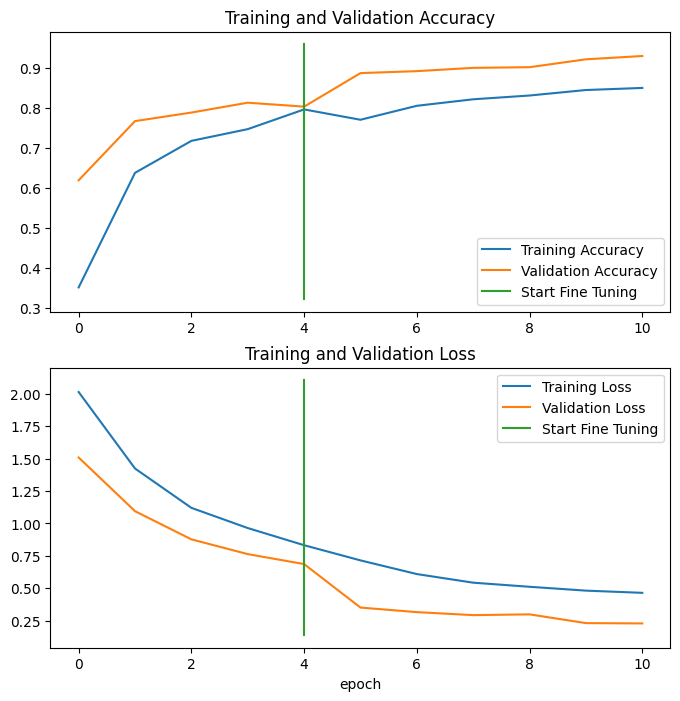

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

Görünüşe göre bu ekstra veri yardımcı oldu! Bu eğriler harika görünüyor. Ve daha uzun süre eğitim alırsak, gelişmeye devam edebilirler.

Daha uzun süre eğitim devam etse sonuçlar daha da iyi olabilir. grafiğe bakarak eğriler daha da yakınlaşabilir.

# Deney verilerimizi TensorBoard'da görüntüleme

Şu anda deneysel sonuçlarımız dizüstü bilgisayarımızın her yerine dağılmış durumda. Bunları biriyle paylaşmak istiyorsak, bir sürü farklı grafik ve metrik alıyor olacaklar... eğlenceli bir zaman değil.

Ama tahmin et ne oldu?

Yardımcı işlevimiz create_tensorflow_callback() ile yaptığımız TensorBoard geri araması sayesinde, tüm zaman boyunca modelleme deneylerimizi takip ediyoruz.

Onları TensorBoard.dev'e yükleyip kontrol etmeye ne dersiniz?

Tensorboard dev yükleme komutuyla ve deneylerimizin günlüğe kaydedildiği dizini iletebiliriz.

🔑 Not: Unutmayın, TensorBoard.dev'e yüklediğiniz her şey herkese açık hale gelir. Paylaşmak istemediğiniz eğitim günlükleri varsa, bunları yüklemeyin.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./transfer_learning \
#   --name "Transfer learning experiments" \
#   --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
#   --one_shot # exits the uploader when upload has finished

Sonuçları TensorBoard.dev'e yükledikten sonra, deneylerimizi görüntülemek ve karşılaştırmak ve gerekirse sonuçlarımızı başkalarıyla paylaşmak için kullanabileceğimiz paylaşılabilir bir bağlantı elde ediyoruz.

Bu not defterinde yaptığımız deneylerin orijinal versiyonlarını buradan görüntüleyebilirsiniz: https://tensorboard.dev/experiment/2O76kw3PQbKl0lByfg5B4w/

🤔 Soru: Hangi model en iyi performansı gösterdi? Bunun neden olduğunu düşünüyorsun? İnce ayar nasıl geçti?

Komut tensorboard geliştirme listesini kullanarak önceki tüm TensorBoard.dev deneylerinizi bulmak için.

In [ ]:
# View previous experiments
# !tensorboard dev list

Ve önceki bir deneyi kaldırmak (ve genel görüntülemeden silmek) istiyorsanız şu komutu kullanabilirsiniz:

Tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID_TO_DELETE]```

In [ ]:
 # Remove previous experiments
# !tensorboard dev delete --experiment_id OUbW0O3pRqqQgAphVBxi8Q

Tensorboard kapanmış...

# 🛠Alıştırmalar

1. Herhangi bir veri kümesinden (tren veya test dosyası) ve herhangi bir sınıftan (örneğin "biftek", "pizza"... vb.) bir görüntüyü görselleştirmek için bir işlev yazın, görselleştirin ve eğitimli bir model kullanarak üzerinde bir tahminde bulunun.

2. Tf.keras.applications.efficientnet_v2 kullanarak 10 dönem için Food Vision verilerinin %10'u üzerinde bir transfer öğrenme modeli eğitmek için özellik çıkarma kullanın. Temel model olarak EfficientNetV2B0. Ağırlıkları dosyaya kaydetmek için ModelCheckpoint geri aramasını kullanın.
  * https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetV2B0
  * https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

3. 2'de eğittiğiniz temel modelin son 20 katmanına 10 dönem daha ince ayar yapın. Nasıl geçti?

4. 2'de eğittiğiniz temel modelin son 30 katmanına 10 dönem daha ince ayar yapın. Nasıl geçti?

# 📖 Müfredat dışı

* TensorFlow'da veri büyütme ile ilgili belgeleri okuyun. https://www.tensorflow.org/tutorials/images/data_augmentation?hl=tr

* Farklı katmanları dondurma ve dondurma kavramına giriş için ULMFit kağıdını (teknik) okuyun. https://arxiv.org/abs/1801.06146

* Öğrenme hızı planlamasını okuyun (bunun için bir TensorFlow geri araması var), bu model eğitimimizi nasıl etkileyebilir? https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

  * Daha uzun süre antrenman yapıyorsanız, muhtemelen ilerlerken öğrenme oranını azaltmak istersiniz... tepenin dibine ne kadar yaklaşırsanız, atmak istediğiniz daha küçük adımlar. Kanepenizin dibinde bozuk para bulmak gibi hayal edin. Başlangıçta kol hareketleriniz büyük olacak ve ne kadar yaklaşırsanız, hareketleriniz o kadar küçülecek.

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb

Makine öğrenimi deneylerini düşünün ve tasarlayın (küçük başlayın ve gerektiğinde artırın)

tf.keras.applications ile transfer öğrenme özelliği çıkarma modelleri oluşturun

Veri büyütme katmanları oluşturun ve bunları doğrudan modellerinize oluşturun

Modelleme deneylerinizi TensorBoard'da karşılaştırın ve bunları TensorBoard.dev'de görselleştirin

Kurs Kaynakları:

https://github.com/mrdbourke/tensorflow-deep-learning

önemli

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/README.md#-05-transfer-learning-in-tensorflow-part-2-fine-tuning-exercises